In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/'My Drive'/'All_Repos'/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
%matplotlib inline

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1744896/45929032 bytes (3.8%)5709824/45929032 bytes (12.4%)9740288/45929032 bytes (21.2%)13762560/45929032 bytes (30.0%)17801216/45929032 bytes (38.8%)21823488/45929032 bytes (47.5%)25878528/45929032 bytes (56.3%)29900800/45929032 bytes (65.1%)33759232/45929032 bytes (73.5%)37609472/45929032 bytes (81.9%)41549824/45929032 bytes (90.5%)45522944/45929032 bytes (99.1%)

## Camera Calibration

Create the camera matrix and distortion coefficient and write it to a pickle

In [0]:
import pickle

images = glob.glob('camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []
  
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
for image in images:
  img = cv2.imread(image)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
  ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
  if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

camera_cal = {"mtx":mtx,"dist":dist}

pickle.dump(camera_cal,open("pickle/cal.p","wb"))

Read mxt and dist from pickle

In [0]:
import pickle
camera_cal = pickle.load( open( "pickle/cal.p", "rb" ) )

mtx = camera_cal["mtx"]
dist = camera_cal["dist"]

# Disrtotion Correction

In [67]:
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(8, 2, figsize=(20, 40))
for ax, img in zip(axs, images):
  img = cv2.imread(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  ax[0].imshow(img)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  ax[1].imshow(undist)
  
plt.show() 
  

Output hidden; open in https://colab.research.google.com to view.

## Threshold

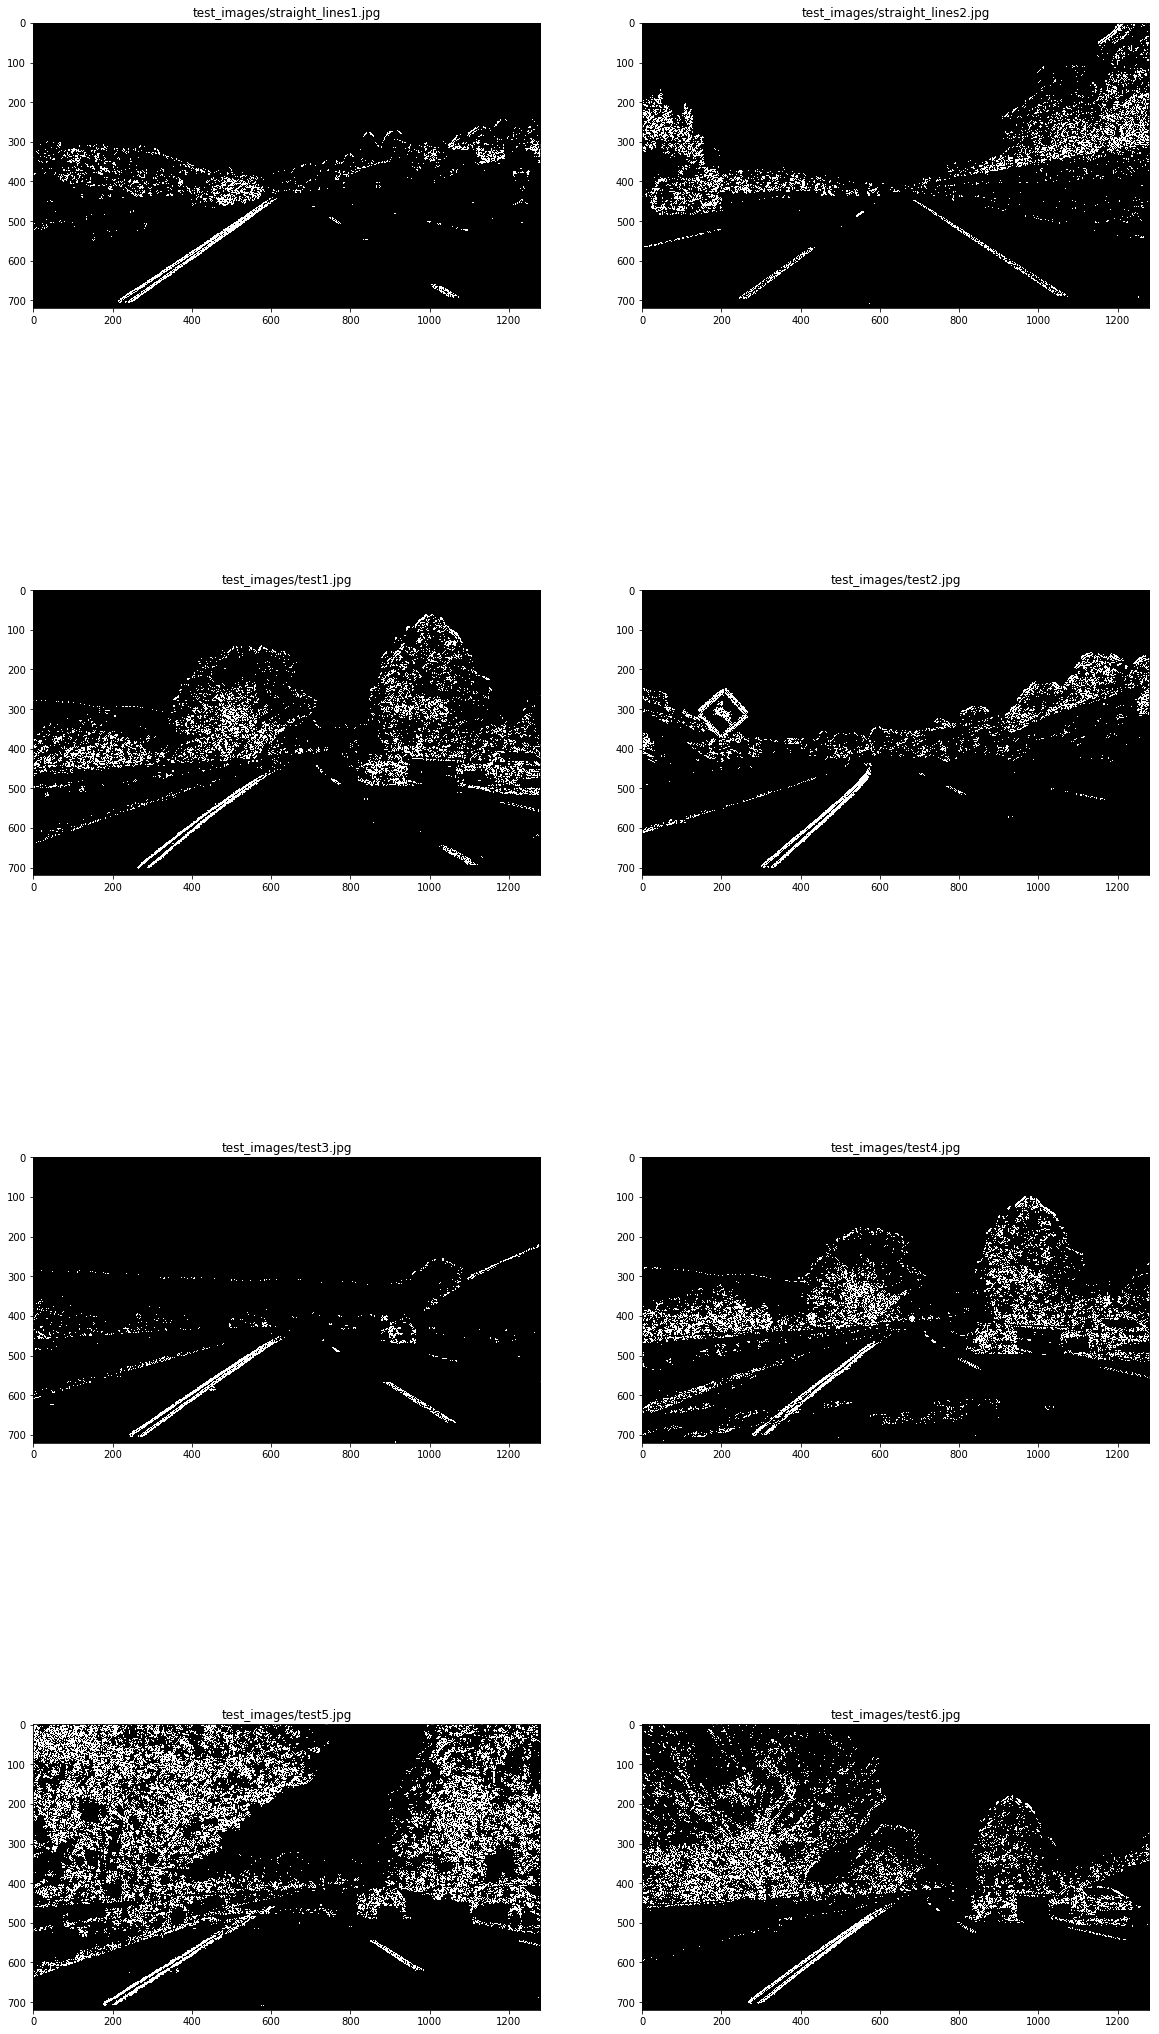

In [98]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 160)):
    # Calculate directional gradient
    # Apply threshold
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #img = cv2.GaussianBlur(img,(3,3),0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    if orient == 'x':
        sobelx = cv2.Sobel(s_channel,cv2.CV_64F,1,0,ksize=sobel_kernel)
        scaled = np.abs(255*sobelx/np.max(sobelx)).astype('uint8')
    elif orient == 'y':
        sobely = cv2.Sobel(s_channel,cv2.CV_64F,0,1,ksize=sobel_kernel)
        scaled = np.abs(255*sobely/np.max(sobely)).astype('uint8')
    
    binary = np.zeros_like(scaled)
    binary[(scaled > thresh[0]) & (scaled <= thresh[1])] = 1
    
    return binary

 
def threshold_mask(img, sobel_kernel=3,s_thresh=(10, 160), sx_thresh=(10,160),sy_thresh=(10,160),dir_thresh=(0,np.pi/2)):
    img = np.copy(img)
    
      
    # Threshold x gradient
    
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=sx_thresh)
    sybinary = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel, thresh=sx_thresh)
    
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) & (sybinary == 1)) ] = 1
    # Stack each channel
    
    return combined
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  result = threshold_mask(undist)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 

## Region of Interest


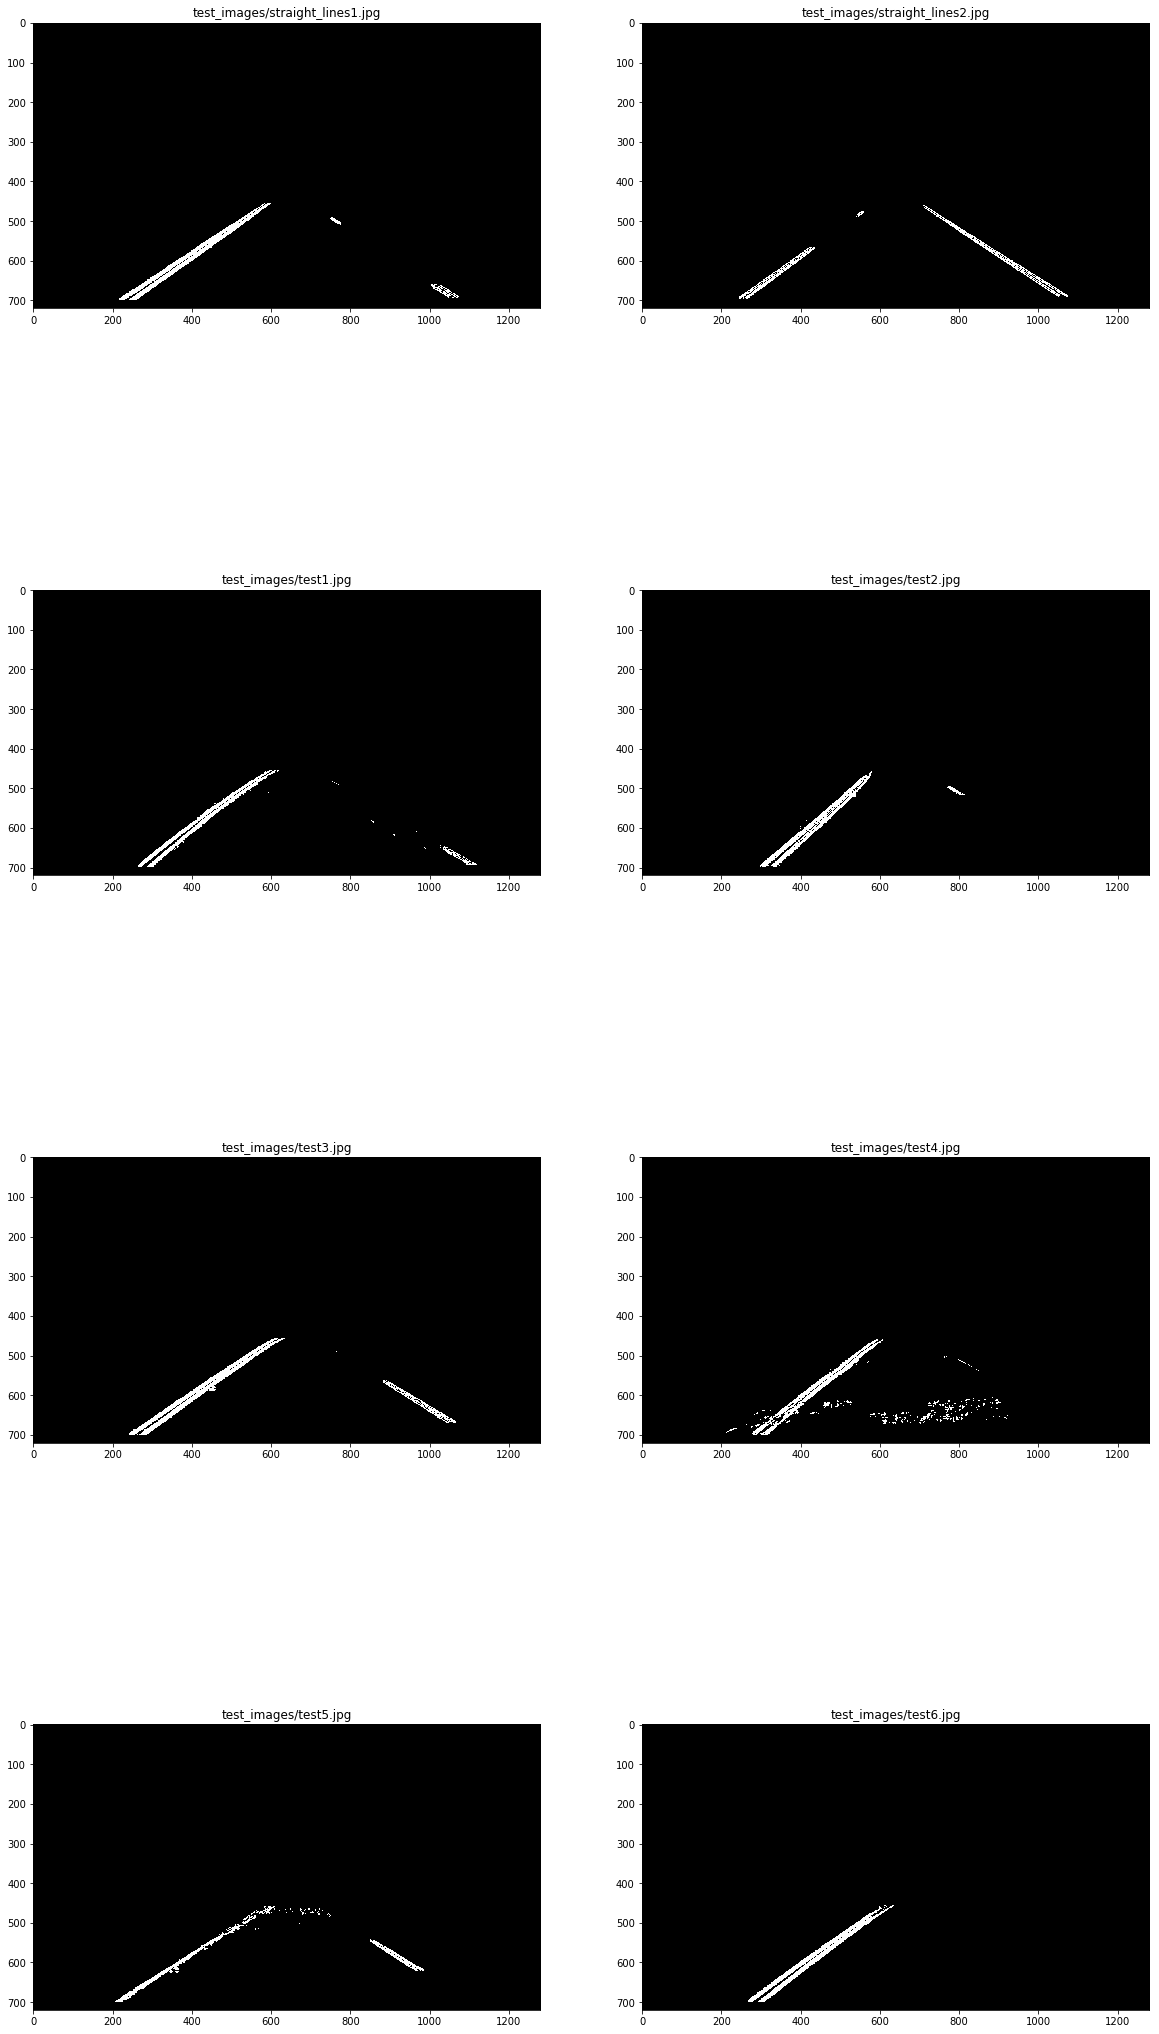

In [64]:
def roi(img):
  
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    vertices = np.array([[[200,700],[585,455],[705,455],[1130,700]]],dtype='int32')
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  result = roi(threshold_masked)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 


## Perspective Transform

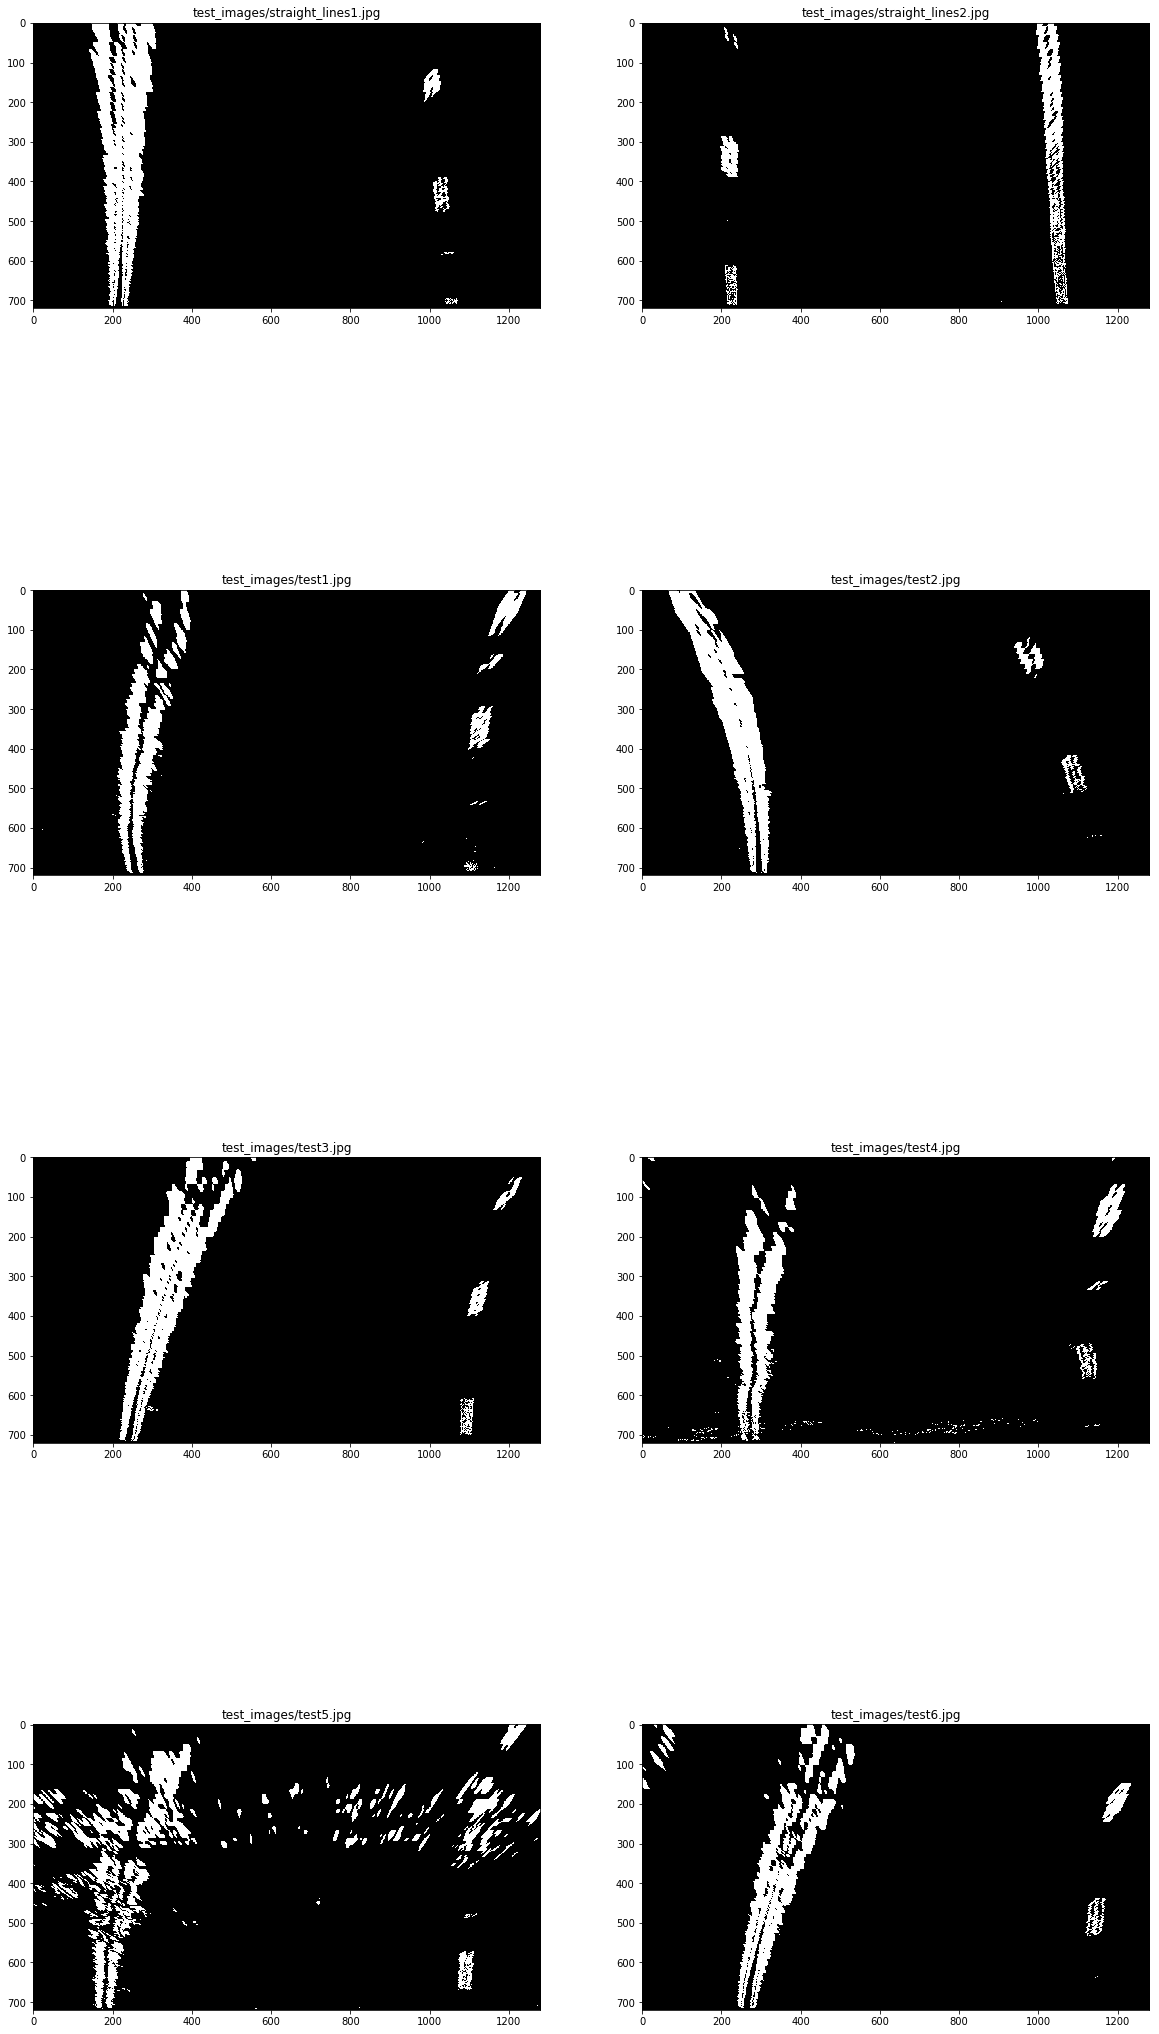

In [86]:
import pickle

def perspective_transform(img):

    
    
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    leftupperpoint  = [585,455]
    rightupperpoint = [705,455]
    leftlowerpoint  = [190,720]
    rightlowerpoint = [1130,720]
    
    src = np.float32([leftupperpoint,rightupperpoint,
                      rightlowerpoint,leftlowerpoint])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
    dst = np.float32([[200,0],[img_size[0]-200,0], [img_size[0]-200,img_size[1]],[200,img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    perspective = {"M":M,"Minv":Minv}
    pickle.dump( perspective,open( "pickle/pers.p", "wb" ) )
    
    



    return warped
  
images = glob.glob('test_images/*.jpg')
fig, axs = plt.subplots(4, 2, figsize=(20, 40))
for ax, img in zip(axs.flat, images):
  path = img
  img = cv2.imread(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  #roi_img = roi(threshold_masked)
  result = perspective_transform(threshold_masked)
  ax.imshow(result,cmap='gray')
  ax.set_title(path)
  
plt.show() 

In [103]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    print(left_curverad/1000,'km',right_curverad/1000,'km')
    
    
    return result,ploty,left_fitx,right_fitx
  
def process_image(img):
  #path = img
  #img = cv2.imread(img)
  #plt.imshow(img)
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  threshold_masked = threshold_mask(undist)
  #roi_img = roi(threshold_masked)
  birds_eye_view = perspective_transform(threshold_masked)
  result,ploty,left_fitx,right_fitx = search_around_poly(birds_eye_view)
  perspective = pickle.load( open( "pickle/pers.p", "rb" ) )
  Minv = perspective['Minv']
  
  #ax.imshow(result,cmap='gray')
  #ax.set_title(path)
  # Create an image to draw the lines on
  warp_zero = np.zeros_like(birds_eye_view).astype(np.uint8)
  color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

  # Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
  pts = np.hstack((pts_left, pts_right))

  # Draw the lane onto the warped blank image
  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

  # Warp the blank back to original image space using inverse perspective matrix (Minv)
  newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
  # Combine the result with the original image
  result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

  return result 

def main():
  white_output = 'lastlaneLines.mp4'
  clip = VideoFileClip('/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Advanced-Lane-Lines/project_video.mp4')
  edge_clip = clip.fl_image(process_image)
  #[process_image(frame) for frame in clip.iter_frames()]
  %time edge_clip.write_videofile(white_output, audio=False)
    
  
    
    #result = find_lane_pipeline(image)
    #return result

if __name__ == '__main__':
  main()

0.39994310700191854 km 1.5857369749102748 km
[MoviePy] >>>> Building video lastlaneLines.mp4
[MoviePy] Writing video lastlaneLines.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]

0.39994310700191854 km 1.5857369749102748 km







  0%|          | 1/1261 [00:00<03:31,  5.95it/s]

0.3743481834526929 km 1.0694317244921154 km







  0%|          | 2/1261 [00:00<03:35,  5.85it/s]




  0%|          | 3/1261 [00:00<03:27,  6.05it/s]

0.3662215843230332 km 0.6483086040455495 km







  0%|          | 4/1261 [00:00<03:23,  6.19it/s]

0.3569663364193791 km 0.5154558744266412 km







  0%|          | 5/1261 [00:00<03:22,  6.20it/s]

0.3403919528118773 km 0.4982733260816366 km







  0%|          | 6/1261 [00:00<03:21,  6.24it/s]

0.38219694062694815 km 0.5941424248157735 km







  1%|          | 7/1261 [00:01<03:20,  6.25it/s]

0.41428881181809785 km 0.48776780395647895 km







  1%|          | 8/1261 [00:01<03:20,  6.25it/s]

0.42808007530389597 km 0.5907083172388767 km







  1%|          | 9/1261 [00:01<03:23,  6.15it/s]

0.4449622595735497 km 2.46926217821188 km







  1%|          | 10/1261 [00:01<03:22,  6.18it/s]

0.4585780764587949 km 3.3559322436600425 km







  1%|          | 11/1261 [00:01<03:21,  6.22it/s]

0.4346791574002255 km 1.237937989262491 km







  1%|          | 12/1261 [00:01<03:22,  6.18it/s]

0.45824387664263333 km 11.15918550588131 km







  1%|          | 13/1261 [00:02<03:22,  6.17it/s]

0.5160432599812901 km 2.0781292269770186 km







  1%|          | 14/1261 [00:02<03:23,  6.13it/s]

0.5581199081304848 km 1.6138055933837823 km







  1%|          | 15/1261 [00:02<03:23,  6.13it/s]

0.5114060972918655 km 1.7504484953598085 km







  1%|▏         | 16/1261 [00:02<03:22,  6.16it/s]

0.4742145919367693 km 2.6044844143243786 km







  1%|▏         | 17/1261 [00:02<03:21,  6.19it/s]

0.46609240018340264 km 4.765630758025325 km







  1%|▏         | 18/1261 [00:02<03:21,  6.16it/s]

0.4314916885063768 km 2.6210975814022714 km







  2%|▏         | 19/1261 [00:03<03:21,  6.17it/s]

0.4253622406181937 km 0.6692127012144886 km







  2%|▏         | 20/1261 [00:03<03:20,  6.19it/s]

0.47338060155290484 km 2.035670808192547 km







  2%|▏         | 21/1261 [00:03<03:20,  6.19it/s]

0.48073694062748196 km 0.5374221527234004 km







  2%|▏         | 22/1261 [00:03<03:19,  6.22it/s]

0.5602696072249158 km 0.4990559622244436 km







  2%|▏         | 23/1261 [00:03<03:19,  6.22it/s]

0.5187025209122488 km 0.2854766144928143 km







  2%|▏         | 24/1261 [00:03<03:17,  6.25it/s]

0.4551458194949895 km 0.6199783380489392 km







  2%|▏         | 25/1261 [00:04<03:17,  6.25it/s]

0.4183374313229027 km 0.7446300983760513 km







  2%|▏         | 26/1261 [00:04<03:16,  6.27it/s]

0.47547208382264633 km 0.9044846565294044 km







  2%|▏         | 27/1261 [00:04<03:16,  6.29it/s]

0.4613898597321322 km 1.3923981589170193 km







  2%|▏         | 28/1261 [00:04<03:16,  6.26it/s]

0.47852521456231073 km 0.7634327605556046 km







  2%|▏         | 29/1261 [00:04<03:17,  6.24it/s]

0.4561855620158524 km 0.49152781725602696 km







  2%|▏         | 30/1261 [00:04<03:17,  6.24it/s]

0.3921547622909345 km 0.39362998138633265 km







  2%|▏         | 31/1261 [00:04<03:16,  6.27it/s]

0.3548219828781879 km 0.5182395508570132 km







  3%|▎         | 32/1261 [00:05<03:13,  6.36it/s]

0.330377679582838 km 0.5070913279909238 km







  3%|▎         | 33/1261 [00:05<03:17,  6.21it/s]

0.33078381826250536 km 0.5928777548950149 km







  3%|▎         | 34/1261 [00:05<03:16,  6.23it/s]

0.315801086657089 km 0.6836145940388377 km







  3%|▎         | 35/1261 [00:05<03:16,  6.23it/s]

0.30537979606975413 km 1.0587847629064795 km







  3%|▎         | 36/1261 [00:05<03:15,  6.26it/s]

0.3012435474230849 km 0.6516433475246308 km







  3%|▎         | 37/1261 [00:05<03:15,  6.25it/s]

0.2925057316272913 km 0.822958375479546 km







  3%|▎         | 38/1261 [00:06<03:14,  6.29it/s]

0.2726384723316127 km 0.9384508689017809 km







  3%|▎         | 39/1261 [00:06<03:15,  6.26it/s]

0.26575861273006474 km 2.4259539109403825 km







  3%|▎         | 40/1261 [00:06<03:15,  6.24it/s]

0.26988093252348816 km 3.1545695145863677 km







  3%|▎         | 41/1261 [00:06<03:14,  6.26it/s]

0.3027767342142539 km 3.3801231239029934 km







  3%|▎         | 42/1261 [00:06<03:15,  6.25it/s]

0.27649031287141523 km 5.669387709889622 km
0.2924627672094567 km 2.5597029672941316 km







  3%|▎         | 43/1261 [00:06<03:31,  5.75it/s]




  3%|▎         | 44/1261 [00:07<03:53,  5.20it/s]

0.31299663480397333 km 3.377629181592471 km







  4%|▎         | 45/1261 [00:07<03:54,  5.17it/s]




  4%|▎         | 46/1261 [00:07<03:39,  5.52it/s]

0.3159468932658742 km 1.0019055483316093 km
0.33295655006036345 km 0.3559981822929 km







  4%|▎         | 47/1261 [00:07<03:41,  5.47it/s]

0.3430891247221288 km 0.5124542532154561 km







  4%|▍         | 48/1261 [00:07<03:51,  5.24it/s]

0.34642480209389137 km 0.4370023492072026 km
0.37678857740987054 km 0.5236133267577703 km







  4%|▍         | 49/1261 [00:08<03:55,  5.14it/s]




  4%|▍         | 50/1261 [00:08<03:54,  5.17it/s]






0.3951822626482287 km 0.5888451532961112 km
0.4122163592935446 km 0.5495165339428862 km


  4%|▍         | 51/1261 [00:08<03:49,  5.28it/s]




  4%|▍         | 52/1261 [00:08<03:49,  5.27it/s]

0.4507158179891498 km 0.847789746447319 km
0.4364767416830288 km 1.8135431134419584 km







  4%|▍         | 53/1261 [00:08<03:49,  5.27it/s]




  4%|▍         | 54/1261 [00:09<03:50,  5.24it/s]

0.47784905020524604 km 1.199870236413845 km
0.4838610262939741 km 1.4503928576081775 km







  4%|▍         | 55/1261 [00:09<03:51,  5.21it/s]




  4%|▍         | 56/1261 [00:09<03:57,  5.07it/s]

0.538389657666939 km 0.6578321434731587 km
0.5710434815418028 km 1.1878398267115926 km







  5%|▍         | 57/1261 [00:09<03:56,  5.09it/s]




  5%|▍         | 58/1261 [00:09<03:52,  5.18it/s]

0.5316940402034329 km 0.545146678925026 km
0.47151423845954826 km 0.4480852430826945 km







  5%|▍         | 59/1261 [00:10<03:50,  5.23it/s]




  5%|▍         | 60/1261 [00:10<03:58,  5.04it/s]

0.44024462855465324 km 0.5623851484544674 km
0.48385714574093003 km 5.308237110305926 km







  5%|▍         | 61/1261 [00:10<03:53,  5.14it/s]




  5%|▍         | 62/1261 [00:10<03:51,  5.17it/s]




  5%|▍         | 63/1261 [00:10<03:42,  5.37it/s]

0.48321456317252026 km 1.1160176711838183 km
0.466726947945123 km 3.587046687950036 km







  5%|▌         | 64/1261 [00:11<04:00,  4.98it/s]

0.4521142143882055 km 5.117559741644554 km
0.4184868325687814 km 2.245946784677808 km







  5%|▌         | 65/1261 [00:11<03:54,  5.10it/s]




  5%|▌         | 66/1261 [00:11<03:45,  5.29it/s]




  5%|▌         | 67/1261 [00:11<03:39,  5.43it/s]

0.4052130443656119 km 3.9444368630902074 km
0.4146283287872133 km 16.637377198757687 km







  5%|▌         | 68/1261 [00:11<03:56,  5.05it/s]

0.4240413935260875 km 14.577953774906122 km







  5%|▌         | 69/1261 [00:12<03:58,  5.01it/s]

0.4111071965744501 km 0.9943286197230035 km
0.45734040890085437 km 0.6894926668677358 km







  6%|▌         | 70/1261 [00:12<03:56,  5.04it/s]




  6%|▌         | 71/1261 [00:12<03:45,  5.27it/s]

0.4351387957376216 km 0.513399151015292 km







  6%|▌         | 72/1261 [00:12<04:02,  4.90it/s]

0.46428975885318013 km 0.9144633388002639 km
0.4899733622683039 km 0.8016312557403286 km







  6%|▌         | 73/1261 [00:12<03:58,  4.97it/s]




  6%|▌         | 74/1261 [00:13<03:54,  5.07it/s]

0.5328037960877421 km 5.69434459533727 km
0.6032687034554612 km 1.487621970753696 km







  6%|▌         | 75/1261 [00:13<03:52,  5.10it/s]




  6%|▌         | 76/1261 [00:13<04:06,  4.80it/s]

0.5785545083886912 km 1.6088922503473755 km







  6%|▌         | 77/1261 [00:13<04:06,  4.80it/s]

0.801284279182952 km 2.977450921650197 km







  6%|▌         | 78/1261 [00:13<04:05,  4.82it/s]

0.9038566343673697 km 0.5546978614425414 km







  6%|▋         | 79/1261 [00:14<04:05,  4.81it/s]

0.890484445994049 km 10.379902341302149 km
0.9335851207561088 km 0.6911516014292929 km







  6%|▋         | 80/1261 [00:14<04:03,  4.86it/s]




  6%|▋         | 81/1261 [00:14<04:01,  4.89it/s]

0.8275157142359197 km 0.5298894113088639 km







  7%|▋         | 82/1261 [00:14<04:02,  4.87it/s]

0.7221686002820665 km 0.5166163639831962 km
0.7870193760186852 km 0.5111445847548753 km







  7%|▋         | 83/1261 [00:14<03:59,  4.91it/s]




  7%|▋         | 84/1261 [00:15<03:56,  4.98it/s]

0.7492513814576509 km 0.6430831180958978 km
0.6274294472344419 km






  7%|▋         | 85/1261 [00:15<04:03,  4.83it/s]

 0.7160751826584332 km







  7%|▋         | 86/1261 [00:15<03:57,  4.95it/s]






0.5738644259940237 km 0.9559169350226906 km
0.47998989518724744 km 2.2388464546376627 km


  7%|▋         | 87/1261 [00:15<03:48,  5.14it/s]




  7%|▋         | 88/1261 [00:15<03:51,  5.07it/s]

0.49565741391491436 km 1.5458591978669143 km
0.4796275818040821 km 62.980960933630925 km







  7%|▋         | 89/1261 [00:16<03:50,  5.08it/s]




  7%|▋         | 90/1261 [00:16<03:45,  5.19it/s]

0.38946150336141017 km 5.7908348350002825 km
0.3997344754177077 km 0.5610757248372469 km







  7%|▋         | 91/1261 [00:16<03:45,  5.20it/s]




  7%|▋         | 92/1261 [00:16<03:56,  4.95it/s]

0.4343487444804063 km 0.48094764271137314 km
0.38664666129580855 km 0.5235605459822178 km







  7%|▋         | 93/1261 [00:16<03:54,  4.98it/s]




  7%|▋         | 94/1261 [00:17<03:57,  4.92it/s]

0.3985942759781257 km 0.49466634345549865 km
0.36942885971110573 km 0.5511842587155891 km







  8%|▊         | 95/1261 [00:17<03:53,  5.00it/s]




  8%|▊         | 96/1261 [00:17<03:49,  5.07it/s]

0.37918010060215795 km 0.6151085081369249 km
0.41183112098684094 km 2.49097754160769 km







  8%|▊         | 97/1261 [00:17<03:49,  5.07it/s]




  8%|▊         | 98/1261 [00:17<03:46,  5.13it/s]

0.39201817291474217 km 1.294834316834992 km







  8%|▊         | 99/1261 [00:18<03:46,  5.13it/s]




  8%|▊         | 100/1261 [00:18<03:40,  5.27it/s]

0.381255611548973 km 1.149874425209485 km
0.3748612910514642 km 1.30877206845011 km







  8%|▊         | 101/1261 [00:18<03:54,  4.94it/s]

0.3707999451266056 km 0.9598736449920662 km
0.3589359811669555 km 1.1013218653304082 km







  8%|▊         | 102/1261 [00:18<03:50,  5.03it/s]




  8%|▊         | 103/1261 [00:18<03:47,  5.10it/s]




  8%|▊         | 104/1261 [00:18<03:39,  5.28it/s]

0.39044416123395365 km 0.4095489561577552 km
0.3657456185767454 km 0.9639400415583651 km







  8%|▊         | 105/1261 [00:19<03:37,  5.32it/s]




  8%|▊         | 106/1261 [00:19<03:33,  5.40it/s]

0.3913188866526119 km 0.40598410142005875 km
0.36253795671536765 km 0.8094391092678301 km







  8%|▊         | 107/1261 [00:19<03:38,  5.28it/s]

0.3728177222324597 km 0.5176602191531117 km
0.35587092879632676 km 0.47716971390145374 km







  9%|▊         | 108/1261 [00:19<03:35,  5.36it/s]




  9%|▊         | 109/1261 [00:19<03:44,  5.14it/s]

0.366660585967552 km 0.911724409311067 km
0.3468570255910501 km 0.8714223043983099 km







  9%|▊         | 110/1261 [00:20<03:48,  5.03it/s]




  9%|▉         | 111/1261 [00:20<03:46,  5.08it/s]

0.3449222252355641 km 2.1766188510889037 km
0.3706081479758425 km 1.086253942235711 km







  9%|▉         | 112/1261 [00:20<03:43,  5.14it/s]




  9%|▉         | 113/1261 [00:20<03:58,  4.81it/s]

0.342793181448491 km 2.9061391995019594 km
0.3378741798249309 km 19.424397260140243 km







  9%|▉         | 114/1261 [00:20<03:51,  4.95it/s]




  9%|▉         | 115/1261 [00:21<03:40,  5.20it/s]

0.3091736702487056 km 1.1125985429253658 km
0.31081601356792055 km 6.618000874480722 km







  9%|▉         | 116/1261 [00:21<03:41,  5.18it/s]




  9%|▉         | 117/1261 [00:21<03:53,  4.89it/s]

0.31093284065142646 km 141.7401634112044 km
0.3069811442169797 km 0.49959549731436137 km







  9%|▉         | 118/1261 [00:21<03:50,  4.95it/s]




  9%|▉         | 119/1261 [00:21<03:40,  5.18it/s]




 10%|▉         | 120/1261 [00:22<03:33,  5.35it/s]

0.31533567396874357 km 5.77764805381367 km
0.31466402027415036 km 0.3054719029702286 km







 10%|▉         | 121/1261 [00:22<03:32,  5.36it/s]




 10%|▉         | 122/1261 [00:22<03:27,  5.48it/s]

0.31605248580521333 km 0.33861746339165955 km
0.32837601956143636 km 0.4261900812230341 km







 10%|▉         | 123/1261 [00:22<03:29,  5.43it/s]

0.3143885965821307 km 0.4573601528036791 km
0.31073416084611166 km






 10%|▉         | 124/1261 [00:22<03:35,  5.28it/s]

 0.48185441231401105 km
0.33954500792328335 km 0.5274048196964656 km







 10%|▉         | 125/1261 [00:23<03:34,  5.29it/s]




 10%|▉         | 126/1261 [00:23<03:33,  5.32it/s]

0.34485891709822475 km 0.4832605633115282 km
0.3575405892278003 km 1.1489429683436885 km







 10%|█         | 127/1261 [00:23<03:34,  5.30it/s]




 10%|█         | 128/1261 [00:23<03:29,  5.40it/s]

0.37068932953134226 km 0.7561056854514919 km







 10%|█         | 129/1261 [00:23<03:41,  5.11it/s]

0.3658606649624895 km 0.6619455131813182 km
0.36910244003180614 km 0.42299128352355825 km







 10%|█         | 130/1261 [00:24<03:42,  5.08it/s]




 10%|█         | 131/1261 [00:24<03:34,  5.28it/s]




 10%|█         | 132/1261 [00:24<03:28,  5.42it/s]

0.36140561491953094 km 0.5741743549302292 km
0.3584519216197427 km 0.5203291380041843 km







 11%|█         | 133/1261 [00:24<03:26,  5.47it/s]




 11%|█         | 134/1261 [00:24<03:23,  5.54it/s]

0.3804467525437141 km 0.39068810274862886 km
0.35789103663998334 km 0.5170098817626001 km







 11%|█         | 135/1261 [00:24<03:30,  5.34it/s]

0.3514438520507115 km 0.5544450253961641 km







 11%|█         | 136/1261 [00:25<03:39,  5.13it/s]






0.3757798366928572 km 0.6792586072212742 km
0.3987936960953041 km 0.6840231509102416 km


 11%|█         | 137/1261 [00:25<03:34,  5.24it/s]




 11%|█         | 138/1261 [00:25<03:31,  5.31it/s]

0.4116291238136466 km 0.587240420536086 km
0.42318981239267905 km 0.9161321949513904 km







 11%|█         | 139/1261 [00:25<03:31,  5.32it/s]




 11%|█         | 140/1261 [00:25<03:36,  5.17it/s]

0.46154812787201743 km 0.4924034213396996 km
0.43052741979475156 km 1.0765923487317812 km







 11%|█         | 141/1261 [00:26<03:41,  5.07it/s]




 11%|█▏        | 142/1261 [00:26<03:44,  4.99it/s]

0.4860281276350306 km 5.109773907427243 km
0.4430133488489063 km 1.5965906081921897 km







 11%|█▏        | 143/1261 [00:26<03:37,  5.15it/s]




 11%|█▏        | 144/1261 [00:26<03:29,  5.32it/s]

0.434248106721623 km 1.888062772802714 km
0.4349538486450832 km 4.198104416879762 km







 11%|█▏        | 145/1261 [00:26<03:31,  5.27it/s]




 12%|█▏        | 146/1261 [00:27<03:27,  5.38it/s]

0.43273252737299184 km 0.9428711923140902 km
0.4966895984590561 km 1.9144225102921637 km







 12%|█▏        | 147/1261 [00:27<03:28,  5.34it/s]




 12%|█▏        | 148/1261 [00:27<03:30,  5.29it/s]

0.43520040782441805 km 1.4948157209954187 km







 12%|█▏        | 149/1261 [00:27<03:40,  5.05it/s]

0.40069704365613096 km 1.2616265819467292 km
0.39864232062760496 km 2.0718906412838427 km







 12%|█▏        | 150/1261 [00:27<03:33,  5.19it/s]




 12%|█▏        | 151/1261 [00:27<03:31,  5.24it/s]




 12%|█▏        | 152/1261 [00:28<03:24,  5.43it/s]

0.4733970066095018 km 1.011470977492237 km
0.49537998562239693 km 5.21450905455005 km







 12%|█▏        | 153/1261 [00:28<03:25,  5.40it/s]

0.42602404944638933 km 2.3700779915703047 km
0.480662149603038 km 2.0761424103172526 km







 12%|█▏        | 154/1261 [00:28<03:26,  5.36it/s]




 12%|█▏        | 155/1261 [00:28<03:25,  5.39it/s]

0.45642233207318433 km 3.04153295557815 km
0.42386583088453206 km 1.9418454493620823 km







 12%|█▏        | 156/1261 [00:28<03:25,  5.39it/s]




 12%|█▏        | 157/1261 [00:29<03:26,  5.34it/s]

0.4378751165078049 km 1.4818845742369595 km
0.3774611289833325 km 1.8232891165970773 km







 13%|█▎        | 158/1261 [00:29<03:31,  5.23it/s]




 13%|█▎        | 159/1261 [00:29<03:35,  5.10it/s]

0.40447660258289214 km 0.8459775740907877 km
0.35386120223796724 km 0.9114000591784187 km







 13%|█▎        | 160/1261 [00:29<03:36,  5.08it/s]




 13%|█▎        | 161/1261 [00:29<03:32,  5.18it/s]

0.3801788499727572 km 0.5709637028723408 km
0.4145945553955578 km 0.7049695088416795 km







 13%|█▎        | 162/1261 [00:30<03:36,  5.07it/s]




 13%|█▎        | 163/1261 [00:30<03:36,  5.08it/s]

0.42092717482456227 km 0.7717366714169797 km
0.40564350813168476 km 1.5936498499255638 km







 13%|█▎        | 164/1261 [00:30<03:33,  5.15it/s]




 13%|█▎        | 165/1261 [00:30<03:30,  5.21it/s]

0.40709565996336056 km 1.3961576829491942 km
0.41128778062739474 km 8.659038780073555 km







 13%|█▎        | 166/1261 [00:30<03:32,  5.15it/s]




 13%|█▎        | 167/1261 [00:31<03:30,  5.21it/s]

0.36194446297730515 km 8.117976818829629 km
0.4118294473800219 km 91.14065042972915 km







 13%|█▎        | 168/1261 [00:31<03:27,  5.27it/s]




 13%|█▎        | 169/1261 [00:31<03:41,  4.94it/s]

0.4410048486723455 km 2.7550793700730867 km







 13%|█▎        | 170/1261 [00:31<03:46,  4.82it/s]

0.44204878283336874 km 1.0003312253383705 km







 14%|█▎        | 171/1261 [00:31<03:44,  4.86it/s]




 14%|█▎        | 172/1261 [00:32<03:31,  5.14it/s]

0.47737786025615125 km 1.7875591017598076 km
0.4438778330485271 km 0.3255976631179616 km







 14%|█▎        | 173/1261 [00:32<03:38,  4.98it/s]

0.4515001199353218 km 0.3060364147516396 km
0.3932426418104938 km 0.44444099074794 km







 14%|█▍        | 174/1261 [00:32<03:38,  4.97it/s]




 14%|█▍        | 175/1261 [00:32<03:31,  5.13it/s]




 14%|█▍        | 176/1261 [00:32<03:25,  5.29it/s]

0.3957503236429998 km 0.6261626497690137 km
0.3941954335746493 km 0.320174911972392 km







 14%|█▍        | 177/1261 [00:33<03:39,  4.95it/s]

0.4135397854904577 km 0.6073138452547949 km
0.4180735061780738 km 0.7422096542272428 km







 14%|█▍        | 178/1261 [00:33<03:36,  5.01it/s]




 14%|█▍        | 179/1261 [00:33<03:26,  5.25it/s]




 14%|█▍        | 180/1261 [00:33<03:20,  5.40it/s]

0.38880931153188575 km 0.6327633845856847 km
0.36597879566324654 km 0.44067879008354743 km







 14%|█▍        | 181/1261 [00:33<03:37,  4.96it/s]

0.3411219458089791 km 0.32935875749113386 km
0.319461645661243 km 0.38027774058750546 km







 14%|█▍        | 182/1261 [00:34<03:35,  5.01it/s]




 15%|█▍        | 183/1261 [00:34<03:26,  5.21it/s]






0.31027206769786153 km 0.3319402760948898 km
0.2944411954650953 km 0.3645902671086139 km


 15%|█▍        | 184/1261 [00:34<03:22,  5.33it/s]




 15%|█▍        | 185/1261 [00:34<03:23,  5.29it/s]

0.29697563826400625 km 0.347966767660869 km
0.2749944172187411 km 0.30014306864027657 km







 15%|█▍        | 186/1261 [00:34<03:26,  5.21it/s]




 15%|█▍        | 187/1261 [00:34<03:29,  5.13it/s]

0.28727645412897423 km 0.3038025738793467 km







 15%|█▍        | 188/1261 [00:35<03:31,  5.07it/s]

0.2830537380645112 km 0.238766238523064 km
0.290073574007833






 15%|█▍        | 189/1261 [00:35<03:33,  5.03it/s]

 km 0.38382351028022965 km
0.3077789541579768 km 0.45328677181691107 km







 15%|█▌        | 190/1261 [00:35<03:28,  5.13it/s]




 15%|█▌        | 191/1261 [00:35<03:24,  5.23it/s]

0.29792506910862643 km 0.5030429013448823 km
0.3175667222049893 km 0.4317068925386225 km







 15%|█▌        | 192/1261 [00:35<03:23,  5.26it/s]




 15%|█▌        | 193/1261 [00:36<03:31,  5.05it/s]

0.3216027771395698 km 0.5650178935626953 km







 15%|█▌        | 194/1261 [00:36<03:32,  5.01it/s]

0.30529529945760947 km 0.7160218368592243 km
0.3409722166518568 km 0.7799447882185567 km







 15%|█▌        | 195/1261 [00:36<03:27,  5.15it/s]




 16%|█▌        | 196/1261 [00:36<03:25,  5.18it/s]

0.36938221415857597 km 0.9559040791133836 km
0.4072153538751599 km 0.4297397344334462 km







 16%|█▌        | 197/1261 [00:36<03:26,  5.15it/s]




 16%|█▌        | 198/1261 [00:37<03:37,  4.88it/s]

0.4341752720185303 km 0.5800642561110863 km







 16%|█▌        | 199/1261 [00:37<03:31,  5.02it/s]

0.5228027000240605 km 0.5511508652439167 km
0.4966300581007286 km 0.796742955253191 km







 16%|█▌        | 200/1261 [00:37<03:29,  5.07it/s]




 16%|█▌        | 201/1261 [00:37<03:39,  4.82it/s]

0.48673863768088604 km 2.290015901365454 km







 16%|█▌        | 202/1261 [00:37<03:41,  4.78it/s]




 16%|█▌        | 203/1261 [00:38<03:31,  5.01it/s]

0.4892382732775349 km 1.7975762305637162 km
0.44209747502160945 km 1.3160722485578107 km







 16%|█▌        | 204/1261 [00:38<03:23,  5.19it/s]

0.4161927825010955 km 0.9672370759466383 km







 16%|█▋        | 205/1261 [00:38<03:35,  4.90it/s]

0.3720985016445841 km 1.6848998687109056 km







 16%|█▋        | 206/1261 [00:38<03:37,  4.84it/s]




 16%|█▋        | 207/1261 [00:38<03:25,  5.12it/s]

0.347417279133464 km 0.9217251081779233 km
0.32496575977894926 km 0.6306562995998759 km







 16%|█▋        | 208/1261 [00:39<03:20,  5.25it/s]

0.3142898246478457 km 0.34253881024202165 km
0.31914294794188375 km 0.3284828752202881 km







 17%|█▋        | 209/1261 [00:39<03:20,  5.25it/s]




 17%|█▋        | 210/1261 [00:39<03:26,  5.09it/s]

0.3355242968815343 km 0.7120601106416232 km
0.3730556328784856 km 0.5695904256028714 km







 17%|█▋        | 211/1261 [00:39<03:26,  5.09it/s]




 17%|█▋        | 212/1261 [00:39<03:24,  5.14it/s]

0.3638162634742262 km 0.5399726180645751 km







 17%|█▋        | 213/1261 [00:40<03:28,  5.03it/s]

0.37340807634209583 km 0.6885425896284816 km
0.3436973405621283 km 1.5072527910348164 km







 17%|█▋        | 214/1261 [00:40<03:34,  4.89it/s]




 17%|█▋        | 215/1261 [00:40<03:27,  5.04it/s]




 17%|█▋        | 216/1261 [00:40<03:20,  5.22it/s]

0.3435961432994244 km 0.912915047058838 km
0.356590723247488 km 0.9104913900370096 km







 17%|█▋        | 217/1261 [00:40<03:33,  4.89it/s]

0.3694174859735555 km 0.7691478655418288 km
0.4169629540654572 km 0.4317474788959583 km







 17%|█▋        | 218/1261 [00:41<03:28,  5.01it/s]




 17%|█▋        | 219/1261 [00:41<03:26,  5.05it/s]




 17%|█▋        | 220/1261 [00:41<03:19,  5.21it/s]

0.3764067578561049 km 0.7081874794590769 km
0.44980721300944687 km 0.7790514866147142 km







 18%|█▊        | 221/1261 [00:41<03:26,  5.04it/s]

0.4359514613137063 km 1.0074257732246379 km







 18%|█▊        | 222/1261 [00:41<03:31,  4.91it/s]

0.45129981115777057 km 1.3767404373126713 km
0.4585957630904719 km 3.454564285818854 km







 18%|█▊        | 223/1261 [00:42<03:26,  5.04it/s]




 18%|█▊        | 224/1261 [00:42<03:20,  5.16it/s]

0.4543567142780624 km 2.149261165245496 km
0.49141626654905474






 18%|█▊        | 225/1261 [00:42<03:23,  5.08it/s]

 km 2.836714165415469 km
0.43374523233650963 km 3.100660869516153 km







 18%|█▊        | 226/1261 [00:42<03:20,  5.15it/s]




 18%|█▊        | 227/1261 [00:42<03:19,  5.19it/s]

0.449436472471419 km 4.206518652039871 km
0.53139267628142 km 4.1304213969359775 km







 18%|█▊        | 228/1261 [00:43<03:16,  5.26it/s]




 18%|█▊        | 229/1261 [00:43<03:24,  5.04it/s]

0.5749654465277266 km 1.781223088794627 km







 18%|█▊        | 230/1261 [00:43<03:28,  4.95it/s]

0.5850080191257738 km 0.680002003267964 km
0.551209572411176 km 0.8593064126706089 km







 18%|█▊        | 231/1261 [00:43<03:26,  4.98it/s]




 18%|█▊        | 232/1261 [00:43<03:17,  5.21it/s]

0.5625264062928247 km 0.5384603557333439 km
0.5815950268838476 km 0.5272235524746901 km







 18%|█▊        | 233/1261 [00:44<03:15,  5.25it/s]




 19%|█▊        | 234/1261 [00:44<03:12,  5.33it/s]

0.5559621011544035 km 0.7597366926274705 km
0.5877475713002795 km 0.9255730865048559 km







 19%|█▊        | 235/1261 [00:44<03:16,  5.23it/s]




 19%|█▊        | 236/1261 [00:44<03:11,  5.36it/s]

0.48335886166999936 km 0.6557764359824287 km







 19%|█▉        | 237/1261 [00:44<03:22,  5.05it/s]

0.4649624326749473 km 0.7408272110546265 km







 19%|█▉        | 238/1261 [00:45<03:23,  5.03it/s]




 19%|█▉        | 239/1261 [00:45<03:17,  5.18it/s]

0.3916874947403413 km 0.9005904992029263 km
0.3764647572197221 km 2.0204876015524023 km







 19%|█▉        | 240/1261 [00:45<03:11,  5.33it/s]

0.38663160512280537 km 0.9872059341649942 km







 19%|█▉        | 241/1261 [00:45<03:19,  5.12it/s]

0.4119461655751306 km 0.7510516088711543 km
0.4412221814247311 km 0.5404027926084718 km







 19%|█▉        | 242/1261 [00:45<03:16,  5.19it/s]




 19%|█▉        | 243/1261 [00:45<03:13,  5.27it/s]




 19%|█▉        | 244/1261 [00:46<03:08,  5.39it/s]

0.397978317620584 km 0.5323070931537126 km
0.4067886112125217 km 0.34949427316376835 km







 19%|█▉        | 245/1261 [00:46<03:19,  5.09it/s]

0.39561877429071446 km 0.3971689182659089 km







 20%|█▉        | 246/1261 [00:46<03:16,  5.15it/s]




 20%|█▉        | 247/1261 [00:46<03:10,  5.32it/s]

0.3668807209748873 km 0.4527337896016783 km
0.3684782815916106 km 0.6078158919964364 km







 20%|█▉        | 248/1261 [00:46<03:06,  5.42it/s]

0.36357591874818235 km 0.5628603918116706 km







 20%|█▉        | 249/1261 [00:47<03:19,  5.08it/s]

0.3500670120412493 km 0.39149684954969455 km
0.3351119300880078 km 0.6275487079341474 km







 20%|█▉        | 250/1261 [00:47<03:15,  5.16it/s]




 20%|█▉        | 251/1261 [00:47<03:17,  5.11it/s]

0.3789231157418769 km 0.8072137757185351 km
0.4409123852433992 km 0.8310072202002234 km







 20%|█▉        | 252/1261 [00:47<03:18,  5.08it/s]




 20%|██        | 253/1261 [00:47<03:28,  4.83it/s]

0.41353950463690153 km 1.4707885769936586 km
0.42952782618439755 km 1.4548695157656362 km







 20%|██        | 254/1261 [00:48<03:23,  4.95it/s]




 20%|██        | 255/1261 [00:48<03:17,  5.10it/s]

0.37754838203053714 km 1.0887558051145334 km
0.36413784952452627 km 0.7957591366048737 km







 20%|██        | 256/1261 [00:48<03:18,  5.07it/s]




 20%|██        | 257/1261 [00:48<03:21,  4.99it/s]

0.36460686893034283 km 0.4961346464556694 km
0.39596655773200773 km 0.6277484124518528 km







 20%|██        | 258/1261 [00:48<03:20,  5.01it/s]




 21%|██        | 259/1261 [00:49<03:13,  5.17it/s]




 21%|██        | 260/1261 [00:49<03:07,  5.34it/s]

0.42586198032439065 km 0.6159328840574844 km
0.45886266411401394 km 0.6979209750250651 km







 21%|██        | 261/1261 [00:49<03:10,  5.24it/s]

0.5107588317839017 km 1.135470886451503 km
0.5037121895668847 km 30.10311368821145 km







 21%|██        | 262/1261 [00:49<03:11,  5.22it/s]




 21%|██        | 263/1261 [00:49<03:13,  5.14it/s]




 21%|██        | 264/1261 [00:50<03:09,  5.27it/s]

0.5106303830638866 km 0.9244080634927844 km
0.5229553170407486 km 1.479798454657412 km







 21%|██        | 265/1261 [00:50<03:25,  4.85it/s]

0.5142839845550362 km 0.3408059792249189 km







 21%|██        | 266/1261 [00:50<03:19,  4.99it/s]

0.5304078708266263 km 0.39202644302036427 km
0.5084511361258336 km 1.1289266741171373 km







 21%|██        | 267/1261 [00:50<03:15,  5.09it/s]




 21%|██▏       | 268/1261 [00:50<03:13,  5.14it/s]

0.4994300532235865 km 0.38131730360196764 km







 21%|██▏       | 269/1261 [00:51<03:27,  4.79it/s]

0.4966432440070062 km 0.4752801866035462 km
0.5119501719639328 km 0.7770254007432568 km







 21%|██▏       | 270/1261 [00:51<03:22,  4.89it/s]




 21%|██▏       | 271/1261 [00:51<03:18,  4.98it/s]

0.5214122048010237 km 2.17749622730616 km
0.4799571009207895 km 2.9899542851878147 km







 22%|██▏       | 272/1261 [00:51<03:16,  5.02it/s]




 22%|██▏       | 273/1261 [00:51<03:28,  4.75it/s]

0.5430108778829495 km 4.1754292820167755 km
0.4479913288549283 km 6.852137479625071 km







 22%|██▏       | 274/1261 [00:52<03:23,  4.86it/s]




 22%|██▏       | 275/1261 [00:52<03:13,  5.09it/s]

0.4621180552519752 km 0.5638150302211936 km
0.5718748421330921 km 0.5923929614767738 km







 22%|██▏       | 276/1261 [00:52<03:10,  5.16it/s]




 22%|██▏       | 277/1261 [00:52<03:17,  4.99it/s]

0.5950740227812882 km 0.7162724477486065 km
0.5910557956360895 km 0.6891698347360289 km







 22%|██▏       | 278/1261 [00:52<03:14,  5.05it/s]




 22%|██▏       | 279/1261 [00:53<03:09,  5.18it/s]






0.6375311983722702 km 0.6290698205938848 km
0.7934034206084976 km 0.6686665662683063 km


 22%|██▏       | 280/1261 [00:53<03:04,  5.31it/s]




 22%|██▏       | 281/1261 [00:53<03:16,  4.99it/s]

0.7403484527293064 km 1.108116162908421 km







 22%|██▏       | 282/1261 [00:53<03:14,  5.04it/s]




 22%|██▏       | 283/1261 [00:53<03:07,  5.22it/s]

0.6391390767227102 km 2.8239334720650016 km
0.7037924038734186 km 1.3094228740807197 km







 23%|██▎       | 284/1261 [00:54<03:02,  5.36it/s]

0.8151172604553203 km 2.6079440923314774 km







 23%|██▎       | 285/1261 [00:54<03:10,  5.12it/s]

0.9216125296277877 km 2.968575610296105 km
0.7770781030024757 km 1.326140052494301 km







 23%|██▎       | 286/1261 [00:54<03:08,  5.16it/s]




 23%|██▎       | 287/1261 [00:54<03:07,  5.21it/s]

0.8450266968493698 km 1.1726775938464757 km
0.8773735051025365 km 0.6851489041131312 km







 23%|██▎       | 288/1261 [00:54<03:05,  5.25it/s]




 23%|██▎       | 289/1261 [00:54<03:08,  5.15it/s]

0.9146384079440574 km 0.7356395992205962 km
0.9958330539374359 km 0.7299635465223818 km







 23%|██▎       | 290/1261 [00:55<03:12,  5.05it/s]




 23%|██▎       | 291/1261 [00:55<03:08,  5.13it/s]




 23%|██▎       | 292/1261 [00:55<03:02,  5.30it/s]

0.8340810008101245 km 0.5470149757879251 km
0.8818208764887404 km 0.6720452081873328 km







 23%|██▎       | 293/1261 [00:55<03:16,  4.93it/s]

0.8888913145856273 km 0.7132879299104229 km
1.1294190857483577 km 1.04278072133667 km







 23%|██▎       | 294/1261 [00:55<03:17,  4.90it/s]




 23%|██▎       | 295/1261 [00:56<03:19,  4.83it/s]

0.8901518959100918 km 1.320579286504321 km
1.1396525426491684 km 2.4376049143972303 km







 23%|██▎       | 296/1261 [00:56<03:14,  4.97it/s]




 24%|██▎       | 297/1261 [00:56<03:06,  5.16it/s]

1.2124669948012186 km 2.4812149828499046 km
1.061475396780963 km 1.2863896074951064 km







 24%|██▎       | 298/1261 [00:56<03:09,  5.08it/s]




 24%|██▎       | 299/1261 [00:56<03:01,  5.30it/s]

1.2083604669143102 km 1.2342360010164266 km
1.2669836616342571 km 1.5399733746052857 km







 24%|██▍       | 300/1261 [00:57<03:01,  5.30it/s]




 24%|██▍       | 301/1261 [00:57<03:01,  5.30it/s]

0.8963401655725134 km 0.7898711143639515 km
1.0961372209193398






 24%|██▍       | 302/1261 [00:57<03:09,  5.07it/s]

 km 0.8416351624553889 km







 24%|██▍       | 303/1261 [00:57<03:10,  5.04it/s]

1.1955367077703871 km 0.8487724345599897 km
1.0512280567329662 km 0.8432910486777763 km







 24%|██▍       | 304/1261 [00:57<03:04,  5.20it/s]




 24%|██▍       | 305/1261 [00:58<03:03,  5.22it/s]

1.2440552825315834 km 1.2045701767916623 km
1.5242515528254106 km 1.7471911474603614 km







 24%|██▍       | 306/1261 [00:58<03:07,  5.09it/s]




 24%|██▍       | 307/1261 [00:58<03:06,  5.10it/s]

1.6217977240482755 km 2.9709063234233493 km
1.3792118739684762 km 1.3214805149500106 km







 24%|██▍       | 308/1261 [00:58<03:07,  5.09it/s]




 25%|██▍       | 309/1261 [00:58<03:01,  5.24it/s]

1.4348543415431712 km 3.0077617437863187 km
1.664633058547921 km 0.8918628982783436 km







 25%|██▍       | 310/1261 [00:59<03:01,  5.24it/s]




 25%|██▍       | 311/1261 [00:59<03:00,  5.27it/s]

5.115807662662307 km 0.7580267447873051 km
3.782823603488604 km 1.889457367166552 km







 25%|██▍       | 312/1261 [00:59<03:04,  5.16it/s]




 25%|██▍       | 313/1261 [00:59<03:00,  5.26it/s]

8.267496965080143 km 0.9592101084162158 km
28.778830489785843 km 2.6464639695192553 km







 25%|██▍       | 314/1261 [00:59<03:01,  5.20it/s]




 25%|██▍       | 315/1261 [01:00<03:09,  4.98it/s]

9.171317171779917 km 1.9518594203516233 km







 25%|██▌       | 316/1261 [01:00<03:08,  5.00it/s]




 25%|██▌       | 317/1261 [01:00<03:02,  5.18it/s]

3.356666343233668 km 2.72404676108796 km
5.861007596795048 km 2.576792894818156 km







 25%|██▌       | 318/1261 [01:00<03:01,  5.19it/s]

120.8491935299227 km 1.2680875777338738 km
9.221107404485615 km 1.6070246451156007 km







 25%|██▌       | 319/1261 [01:00<03:04,  5.10it/s]




 25%|██▌       | 320/1261 [01:01<03:07,  5.01it/s]

2.6446643665432603 km 0.9290910492159493 km







 25%|██▌       | 321/1261 [01:01<03:11,  4.91it/s]

6.539133386209447 km 2.459838439204615 km
5.757046471354777 km 1.9348072495343238 km







 26%|██▌       | 322/1261 [01:01<03:11,  4.90it/s]




 26%|██▌       | 323/1261 [01:01<03:14,  4.83it/s]

9.731735196208362 km 1.2826489938319763 km
87.30648504073851 km 1.5282810771956343 km







 26%|██▌       | 324/1261 [01:01<03:06,  5.04it/s]




 26%|██▌       | 325/1261 [01:02<02:59,  5.22it/s]

18.078134174869724 km 1.1008607600792073 km
13.435943075577583 km 0.8900336635174858 km







 26%|██▌       | 326/1261 [01:02<03:00,  5.19it/s]




 26%|██▌       | 327/1261 [01:02<02:58,  5.23it/s]

18.15047802343223 km 1.02518538328543 km
8.258116657807497 km 1.2883677808707512 km







 26%|██▌       | 328/1261 [01:02<03:00,  5.16it/s]




 26%|██▌       | 329/1261 [01:02<03:02,  5.10it/s]

4.886264549778824 km 2.510516979468459 km







 26%|██▌       | 330/1261 [01:03<03:12,  4.85it/s]

7.403591916576226 km 64.58724387713285 km
38.19872576114592 km 3.281429560683753 km







 26%|██▌       | 331/1261 [01:03<03:06,  4.98it/s]




 26%|██▋       | 332/1261 [01:03<03:01,  5.12it/s]

63.722771714568346 km 1.2240428970316772 km
24.319853976924726 km 4.053334171061409 km







 26%|██▋       | 333/1261 [01:03<02:56,  5.25it/s]




 26%|██▋       | 334/1261 [01:03<03:03,  5.06it/s]

20.55854294134925 km 4.390574455776758 km
7.498713849084761 km 5.619750952937791 km







 27%|██▋       | 335/1261 [01:04<03:00,  5.13it/s]




 27%|██▋       | 336/1261 [01:04<02:57,  5.20it/s]

11.301623981851314 km 11.62340027509246 km
9.882912116848901 km 526.8913130700687 km







 27%|██▋       | 337/1261 [01:04<02:56,  5.23it/s]




 27%|██▋       | 338/1261 [01:04<03:06,  4.95it/s]

4.612641650305334 km 43.89098388106236 km
3.800115945261257 km 18.0809243306348 km







 27%|██▋       | 339/1261 [01:04<03:04,  5.00it/s]




 27%|██▋       | 340/1261 [01:05<03:03,  5.02it/s]

16.530368310971458 km 63.29864107355144 km
7.3957020383124945 km 2.2253480495953064 km







 27%|██▋       | 341/1261 [01:05<03:00,  5.11it/s]




 27%|██▋       | 342/1261 [01:05<03:12,  4.77it/s]

5.14569095259081 km 0.6803641109384998 km
20.611472610663032 km 0.5987450434666303 km







 27%|██▋       | 343/1261 [01:05<03:08,  4.87it/s]




 27%|██▋       | 344/1261 [01:05<03:00,  5.08it/s]






20.80050622024795 km 9.172187686856086 km
34.23533933510898 km 1.7487648553579647 km


 27%|██▋       | 345/1261 [01:05<02:55,  5.21it/s]




 27%|██▋       | 346/1261 [01:06<02:57,  5.15it/s]

2.1748821737393524 km 0.5060240618970832 km
2.98810009266125 km 6.278540718416099 km







 28%|██▊       | 347/1261 [01:06<02:57,  5.16it/s]




 28%|██▊       | 348/1261 [01:06<02:58,  5.10it/s]

37.235582068699195 km 5.796175919696828 km
3.7211020537324617 km 4.350167164152652 km







 28%|██▊       | 349/1261 [01:06<02:59,  5.07it/s]




 28%|██▊       | 350/1261 [01:06<02:59,  5.08it/s]

19.630054615514624 km 2.0244645281725275 km
5.174865650815176 km 6.9233649538747635 km







 28%|██▊       | 351/1261 [01:07<02:59,  5.06it/s]




 28%|██▊       | 352/1261 [01:07<02:56,  5.15it/s]

3.011554587282707 km 5.996525264945333 km
4.142380122223048 km 22.829950855109914 km







 28%|██▊       | 353/1261 [01:07<02:57,  5.11it/s]




 28%|██▊       | 354/1261 [01:07<03:09,  4.79it/s]

3.8056821576687896 km 0.6651484219132129 km
3.1750201770871365 km 0.8333731002758693 km







 28%|██▊       | 355/1261 [01:08<03:07,  4.82it/s]




 28%|██▊       | 356/1261 [01:08<03:01,  5.00it/s]

2.5404447608049345 km 1.2926449992494484 km
1.1721482656911733 km 2.436899572101741 km







 28%|██▊       | 357/1261 [01:08<02:55,  5.16it/s]




 28%|██▊       | 358/1261 [01:08<02:57,  5.10it/s]

6.515200845916832 km 1.6615330956187115 km
1.5951956326687753 km 1.1922275216413192 km







 28%|██▊       | 359/1261 [01:08<02:57,  5.09it/s]




 29%|██▊       | 360/1261 [01:08<02:57,  5.06it/s]

291.3706143292524 km 1.8290168740054114 km
3.5469853395455853 km 1.4442834554629167 km







 29%|██▊       | 361/1261 [01:09<02:53,  5.19it/s]




 29%|██▊       | 362/1261 [01:09<03:02,  4.91it/s]

3.0230546827759572 km 2.7327858201444406 km
1.1382102554832496 km 2.679707574943508 km







 29%|██▉       | 363/1261 [01:09<02:58,  5.02it/s]




 29%|██▉       | 364/1261 [01:09<02:52,  5.19it/s]






0.7885645692055727 km 3.0252845020983687 km
0.7602431634201505 km 41.83584441488814 km


 29%|██▉       | 365/1261 [01:09<02:49,  5.30it/s]




 29%|██▉       | 366/1261 [01:10<02:57,  5.04it/s]

0.8689008884692966 km 1.8473137263593677 km







 29%|██▉       | 367/1261 [01:10<03:04,  4.83it/s]

0.7343774560674101 km 2.3918097531730136 km
0.7535941895801661 km 2.3906770633150165 km







 29%|██▉       | 368/1261 [01:10<03:00,  4.95it/s]




 29%|██▉       | 369/1261 [01:10<02:54,  5.10it/s]

0.8051219519252458 km 1.4830671451458939 km
0.9344552183602143






 29%|██▉       | 370/1261 [01:10<02:57,  5.03it/s]

 km 0.5366403289634349 km
1.0949095691240822 km 935.5307984178232 km







 29%|██▉       | 371/1261 [01:11<02:55,  5.08it/s]




 30%|██▉       | 372/1261 [01:11<02:51,  5.17it/s]

1.293724630616616 km 5.048173258971349 km
1.8589069235224185 km 14.961847826071518 km







 30%|██▉       | 373/1261 [01:11<02:50,  5.21it/s]




 30%|██▉       | 374/1261 [01:11<03:01,  4.88it/s]

2.4486909183301826 km 3.3409131285012115 km
5.707877954399113 km 377.78964351785265 km







 30%|██▉       | 375/1261 [01:11<03:00,  4.91it/s]




 30%|██▉       | 376/1261 [01:12<02:55,  5.03it/s]

4.071035395255321 km 6.913718669102503 km
2.0794679911117266 km 0.711089263714143 km







 30%|██▉       | 377/1261 [01:12<02:52,  5.12it/s]




 30%|██▉       | 378/1261 [01:12<03:04,  4.80it/s]

1.7780673496594046 km 2.3941134851339907 km
2.2971238613667504 km 11.736113774659175 km







 30%|███       | 379/1261 [01:12<03:01,  4.87it/s]




 30%|███       | 380/1261 [01:12<02:58,  4.94it/s]

1.7462109071045249 km 0.6891161277945617 km
3.6728527760830416 km 2.2561463024483435 km







 30%|███       | 381/1261 [01:13<02:55,  5.02it/s]




 30%|███       | 382/1261 [01:13<03:07,  4.68it/s]

2.369190116367958 km 4.312017703142982 km







 30%|███       | 383/1261 [01:13<03:07,  4.69it/s]

2.184408518492876 km 36.92139360142726 km
1.7675654969159345 km 9.498508673046492 km







 30%|███       | 384/1261 [01:13<02:59,  4.88it/s]




 31%|███       | 385/1261 [01:13<02:54,  5.02it/s]

1.705443834740465 km 12.233431215291708 km







 31%|███       | 386/1261 [01:14<03:02,  4.78it/s]

1.8877778096133497 km 1091.5197795078784 km







 31%|███       | 387/1261 [01:14<03:01,  4.83it/s]

4.093527886553438 km 12.104175262741142 km
3.4808513283495595 km 12.660187079908873 km







 31%|███       | 388/1261 [01:14<02:56,  4.96it/s]




 31%|███       | 389/1261 [01:14<02:50,  5.12it/s]

2.8302039674348736 km 2.7151423109183863 km







 31%|███       | 390/1261 [01:15<03:03,  4.75it/s]

3.591733199421467 km 0.732128968295105 km
2.5457817679042667 km 0.3994754337153102 km







 31%|███       | 391/1261 [01:15<03:00,  4.82it/s]




 31%|███       | 392/1261 [01:15<02:55,  4.96it/s]






4.65955216872036 km 0.5554815090101076 km
7.306568528707131 km 433.7965936548788 km


 31%|███       | 393/1261 [01:15<02:49,  5.13it/s]




 31%|███       | 394/1261 [01:15<02:50,  5.09it/s]

6.573664561128512 km 5.153843963339704 km
4.620881775614939 km 124.46160386776661 






 31%|███▏      | 395/1261 [01:15<02:52,  5.01it/s]

km







 31%|███▏      | 396/1261 [01:16<02:54,  4.95it/s]

5.485781502321452 km 23.91875879911126 km







 31%|███▏      | 397/1261 [01:16<02:51,  5.03it/s]

2.8339280758552934 km 3.15011885218277 km







 32%|███▏      | 398/1261 [01:16<03:04,  4.69it/s]

2.2236549392559684 km 2.373757693634135 km
1.788245529766642 km 2.1726751797057413 km







 32%|███▏      | 399/1261 [01:16<02:59,  4.80it/s]




 32%|███▏      | 400/1261 [01:17<02:54,  4.94it/s]

6.2620609746561735 km 2.28744432115611 km
6.004895705220531 km 1.1443054870256393 km







 32%|███▏      | 401/1261 [01:17<02:49,  5.06it/s]




 32%|███▏      | 402/1261 [01:17<02:48,  5.09it/s]

10.526918793159334 km 0.7199201565587087 km
9.907876635226806 km 0.5392470861386363 km







 32%|███▏      | 403/1261 [01:17<02:48,  5.09it/s]




 32%|███▏      | 404/1261 [01:17<02:49,  5.07it/s]

17.553520827437385 km 0.5842508930475806 km
7.753761505202882 km 3.1042785233529333 km







 32%|███▏      | 405/1261 [01:17<02:45,  5.16it/s]




 32%|███▏      | 406/1261 [01:18<02:47,  5.10it/s]

9.636979074627906 km 2.0676888766962658 km







 32%|███▏      | 407/1261 [01:18<02:59,  4.76it/s]

6.163698942172597 km 2.1965538534064235 km







 32%|███▏      | 408/1261 [01:18<02:59,  4.75it/s]

9.781267260664324 km 4.279721425776235 km
10.225647331182751 km 7.254345720626523 km







 32%|███▏      | 409/1261 [01:18<02:55,  4.86it/s]




 33%|███▎      | 410/1261 [01:19<03:03,  4.65it/s]

76.98957712282582 km 5.042396330205453 km
6.610126066524351 km 4.393446198428812 km







 33%|███▎      | 411/1261 [01:19<02:58,  4.76it/s]




 33%|███▎      | 412/1261 [01:19<02:52,  4.91it/s]

119.84155119156355 km 2.8243583963278733 km
7.871283965326175 km 1.0289073262486252 km







 33%|███▎      | 413/1261 [01:19<02:48,  5.03it/s]




 33%|███▎      | 414/1261 [01:19<02:47,  5.06it/s]

9.104693662224982 km 0.5060885683478422 km







 33%|███▎      | 415/1261 [01:20<02:57,  4.76it/s]

2.5960072696251477 km 0.6740882136117308 km
2.1361418151824534 km 0.6799244782207218 km







 33%|███▎      | 416/1261 [01:20<02:53,  4.86it/s]




 33%|███▎      | 417/1261 [01:20<02:47,  5.04it/s]

2.6008004598835943 km 2.2631602916174307 km







 33%|███▎      | 418/1261 [01:20<02:59,  4.69it/s]

3.239276770974641 km 4.972985755153743 km







 33%|███▎      | 419/1261 [01:20<02:56,  4.78it/s]

4.22205479922085 km 5.491699607455024 km
3.774091964849469 km 5.97262792414306 km







 33%|███▎      | 420/1261 [01:21<02:51,  4.92it/s]




 33%|███▎      | 421/1261 [01:21<02:51,  4.91it/s]

41.44585736483059 km 5.302871251135718 km







 33%|███▎      | 422/1261 [01:21<03:06,  4.49it/s]

6.349232025684193 km 3.5204677306805787 km
3.55480811831867 km 2.3740553840299574 km







 34%|███▎      | 423/1261 [01:21<03:00,  4.63it/s]




 34%|███▎      | 424/1261 [01:21<02:50,  4.90it/s]

3.945473423307181 km 2.524354430515063 km
4.28521940068205 km 1.288769157540375 km







 34%|███▎      | 425/1261 [01:22<02:49,  4.93it/s]




 34%|███▍      | 426/1261 [01:22<02:57,  4.71it/s]

5.350634922556475 km 0.7634689939208169 km







 34%|███▍      | 427/1261 [01:22<03:01,  4.59it/s]

5.984638460621042 km 0.9170294747519339 km
9.354310898070974 






 34%|███▍      | 428/1261 [01:22<02:57,  4.69it/s]




 34%|███▍      | 429/1261 [01:23<02:49,  4.90it/s]

km 0.6556126743868461 km
9.998002218062563 km 0.8151106746473031 km







 34%|███▍      | 430/1261 [01:23<02:55,  4.73it/s]

4.6741556431078015 km 0.7053325300446793 km







 34%|███▍      | 431/1261 [01:23<02:54,  4.75it/s]

73.67061496703532 km 1.5464605379954128 km
81.88421919685717 km 0.6915313800694116 km







 34%|███▍      | 432/1261 [01:23<02:51,  4.83it/s]




 34%|███▍      | 433/1261 [01:23<02:45,  5.00it/s]

10.089328783623694 km 0.9499040519137671 km
22.211825816830757 km 






 34%|███▍      | 434/1261 [01:24<02:47,  4.93it/s]

5.702797104625694 km







 34%|███▍      | 435/1261 [01:24<02:51,  4.80it/s]

9.063615298239421 km 1.967450048329384 km







 35%|███▍      | 436/1261 [01:24<02:55,  4.71it/s]

4.486833899572359 km 5.213627865769932 km
2.0654636558367026 km 2.7342520963017045 km







 35%|███▍      | 437/1261 [01:24<02:46,  4.94it/s]




 35%|███▍      | 438/1261 [01:24<02:54,  4.72it/s]

3.6728876245558353 km 2.801266122055235 km







 35%|███▍      | 439/1261 [01:25<02:55,  4.69it/s]

2.6671563331046473 km 2.7062095586679686 km
1.6331824883064539 km 0.8992865617938858 km







 35%|███▍      | 440/1261 [01:25<02:50,  4.80it/s]




 35%|███▍      | 441/1261 [01:25<02:46,  4.93it/s]

3.3435928171224494 km 1.2877868748267918 km







 35%|███▌      | 442/1261 [01:25<02:51,  4.79it/s]

2.5880339944975925 km 1.4906817155398528 km







 35%|███▌      | 443/1261 [01:25<02:51,  4.76it/s]

3.0103618333890556 km 1.9220146419961432 km
1.8498321237005264 km 2.0480781287479823 km







 35%|███▌      | 444/1261 [01:26<02:47,  4.88it/s]




 35%|███▌      | 445/1261 [01:26<02:44,  4.97it/s]

2.837298119830353 km 2.4038791347345367 km







 35%|███▌      | 446/1261 [01:26<02:58,  4.57it/s]

1.9553563631154094 km 3.8948095153067293 km
3.5738182509933063 km 4.223522359262116 km







 35%|███▌      | 447/1261 [01:26<02:53,  4.68it/s]




 36%|███▌      | 448/1261 [01:26<02:45,  4.90it/s]

3.036456804380126 km 4.435115723488732 km
1.9614720449733485 km 1.0134741485498755 km







 36%|███▌      | 449/1261 [01:27<02:42,  5.01it/s]




 36%|███▌      | 450/1261 [01:27<02:51,  4.74it/s]

43.24181277773021 km 0.6942420768039004 km
4.069419034411744 km 0.6929363097563255 km







 36%|███▌      | 451/1261 [01:27<02:49,  4.79it/s]




 36%|███▌      | 452/1261 [01:27<02:44,  4.92it/s]

4.022441874910553 km 2.2834241788109995 km
3.2134692750814406 km 2.603940368911925 km







 36%|███▌      | 453/1261 [01:27<02:42,  4.98it/s]




 36%|███▌      | 454/1261 [01:28<02:53,  4.66it/s]

10.72665342406667 km 4.906829200537522 km
6.670761767848564 km 4.151747344577265 km







 36%|███▌      | 455/1261 [01:28<02:49,  4.76it/s]




 36%|███▌      | 456/1261 [01:28<02:44,  4.91it/s]

5.271744057486754 km 3.0167637671426344 km
3.9307809143580386 km 3.8067885222365363 km







 36%|███▌      | 457/1261 [01:28<02:40,  5.02it/s]




 36%|███▋      | 458/1261 [01:29<02:51,  4.68it/s]

12.128503459951627 km 21.191014311374076 km







 36%|███▋      | 459/1261 [01:29<02:50,  4.71it/s]

3.8591699877552412 km 11.046300029085051 km







 36%|███▋      | 460/1261 [01:29<02:48,  4.75it/s]

4.251558185479569 km 12.417675722110658 km
3.212904999387488 km 1.045431462778521 km







 37%|███▋      | 461/1261 [01:29<02:43,  4.89it/s]




 37%|███▋      | 462/1261 [01:29<02:49,  4.71it/s]

9.438466043047766 km 0.6649409967486182 km







 37%|███▋      | 463/1261 [01:30<02:50,  4.67it/s]

5.5115062567748785 km 0.6644409205543456 km







 37%|███▋      | 464/1261 [01:30<02:45,  4.81it/s]

2.402917594858614 km 0.8149277467839644 km







 37%|███▋      | 465/1261 [01:30<02:45,  4.82it/s]

5.598767038003534 km 7.620714455856713 km
1.7788821075229642 km 2.1070983121230897 km







 37%|███▋      | 466/1261 [01:30<02:44,  4.84it/s]




 37%|███▋      | 467/1261 [01:30<02:43,  4.86it/s]

2.0847016357994352 km 1.85686653464256 km







 37%|███▋      | 468/1261 [01:31<02:49,  4.68it/s]

2.9082421030316548 km 1.3563352101618518 km
2.279409244629881 km 1.3952569175184752 km







 37%|███▋      | 469/1261 [01:31<02:43,  4.85it/s]




 37%|███▋      | 470/1261 [01:31<02:48,  4.69it/s]

2.2029959948091444 km 1.6276699617634558 km







 37%|███▋      | 471/1261 [01:31<02:47,  4.71it/s]

5.1099054711872505 km 1.6911226611292682 km







 37%|███▋      | 472/1261 [01:31<02:45,  4.77it/s]

17.611699787582374 km 1.111847781008333 km







 38%|███▊      | 473/1261 [01:32<02:45,  4.76it/s]

28.7512275911083 km 0.6224395772269633 km







 38%|███▊      | 474/1261 [01:32<02:46,  4.74it/s]

5.542246468890896 km 0.7552962530370279 km







 38%|███▊      | 475/1261 [01:32<02:45,  4.76it/s]

1.9079579182645239 km 0.5986571739350849 km







 38%|███▊      | 476/1261 [01:32<02:48,  4.67it/s]

5.076321766947701 km 0.6899693377218316 km







 38%|███▊      | 477/1261 [01:33<02:47,  4.67it/s]

3.163351297519827 km 0.672135360517922 km







 38%|███▊      | 478/1261 [01:33<02:55,  4.46it/s]

2.4308000694649383 km 4.71302782159326 km
5.962433254737013 km 2.8616065204048886 km







 38%|███▊      | 479/1261 [01:33<02:49,  4.62it/s]




 38%|███▊      | 480/1261 [01:33<02:41,  4.83it/s]

3.5455243694460234 km 2.252466642036415 km
2.363749427731137 km 29.556077507042396 km







 38%|███▊      | 481/1261 [01:33<02:35,  5.01it/s]




 38%|███▊      | 482/1261 [01:34<02:36,  4.99it/s]

1.7817613845493738 km 86.61824459467371 km







 38%|███▊      | 483/1261 [01:34<02:48,  4.63it/s]

2.985920263849695 km 14.182186104798209 km
4.615179014209148 km 11.926334568415935 km







 38%|███▊      | 484/1261 [01:34<02:43,  4.74it/s]




 38%|███▊      | 485/1261 [01:34<02:38,  4.89it/s]

15.585505563585652 km 0.9997092750141475 km







 39%|███▊      | 486/1261 [01:34<02:50,  4.55it/s]

4.045782778096395 km 1.6199582035529638 km
27.697971920512725 km 1.0032821157123422 km







 39%|███▊      | 487/1261 [01:35<02:45,  4.67it/s]




 39%|███▊      | 488/1261 [01:35<02:40,  4.81it/s]

7.890701776844053 km 0.7692704116036 km







 39%|███▉      | 489/1261 [01:35<02:41,  4.79it/s]

23.442723008673287 km 1.480115951257307 km
541.2451211438472 km 4.677968047373457 km







 39%|███▉      | 490/1261 [01:35<02:39,  4.82it/s]




 39%|███▉      | 491/1261 [01:35<02:41,  4.76it/s]

10.257083814358229 km 5.182566901019991 km
15.735884574198415 






 39%|███▉      | 492/1261 [01:36<02:38,  4.84it/s]

km 12.77636205985914 km
6.345631519279688 km 4.420300995166154 km







 39%|███▉      | 493/1261 [01:36<02:34,  4.97it/s]




 39%|███▉      | 494/1261 [01:36<02:50,  4.50it/s]

10.4773314820606 km 7.5904724334811835 km







 39%|███▉      | 495/1261 [01:36<02:50,  4.50it/s]

8.112388714943426 km 12.926904264973523 km
4.127554017073858 km 12.388692786448281 km







 39%|███▉      | 496/1261 [01:37<02:44,  4.64it/s]




 39%|███▉      | 497/1261 [01:37<02:36,  4.87it/s]

25.29521045214758 km 1.5351530321024256 km
9.608943658104485 km 3.9581539100672147 km







 39%|███▉      | 498/1261 [01:37<02:35,  4.90it/s]




 40%|███▉      | 499/1261 [01:37<02:34,  4.95it/s]

21.819026640253142 km 1.074250623675667 km
3.7614334458146508 km 0.7407244203146888 km







 40%|███▉      | 500/1261 [01:37<02:33,  4.97it/s]




 40%|███▉      | 501/1261 [01:38<02:29,  5.10it/s]

8.120519163916551 km 0.4892531541029303 km
5.278397328796515 km 0.6340157353820273 km







 40%|███▉      | 502/1261 [01:38<02:31,  5.02it/s]




 40%|███▉      | 503/1261 [01:38<02:28,  5.12it/s]

4.984653325247161 km 2.0146241018350683 km
5.004180557802297 km 2.2691567438775073 km







 40%|███▉      | 504/1261 [01:38<02:27,  5.13it/s]




 40%|████      | 505/1261 [01:38<02:23,  5.28it/s]

14.73086958539991 km 13.34502754031746 km
4.0697241566064335 km 7.119354650047621 km







 40%|████      | 506/1261 [01:38<02:24,  5.22it/s]




 40%|████      | 507/1261 [01:39<02:32,  4.93it/s]

2.549335506932915 km 4.711050033273789 km
1.5186033760039934 km 2.192766844429208 km







 40%|████      | 508/1261 [01:39<02:30,  4.99it/s]




 40%|████      | 509/1261 [01:39<02:25,  5.15it/s]

1.9324809804880139 km 0.5702723746761731 km







 40%|████      | 510/1261 [01:39<02:35,  4.82it/s]

2.4683042799525263 km 0.4876814080392526 km







 41%|████      | 511/1261 [01:40<02:34,  4.87it/s]

8.950584125520589 km 0.5276120898569385 km
12.7896395776144 km 0.6252909658777004 km







 41%|████      | 512/1261 [01:40<02:30,  4.99it/s]




 41%|████      | 513/1261 [01:40<02:25,  5.13it/s]

4.01902585719124 km 0.589243083267891 km







 41%|████      | 514/1261 [01:40<02:33,  4.86it/s]

4.111603250295164 km 1.1093220531075187 km







 41%|████      | 515/1261 [01:40<02:31,  4.91it/s]

4.552166827179142 km 1.458106514692024 km
0.8968558462622533 km 2.2381022393834193 km







 41%|████      | 516/1261 [01:41<02:31,  4.90it/s]




 41%|████      | 517/1261 [01:41<02:31,  4.90it/s]

1.975092979743157 km 2.156118722075823 km
2.861618114496629 km 3.9877037310320116 km







 41%|████      | 518/1261 [01:41<02:31,  4.90it/s]




 41%|████      | 519/1261 [01:41<02:27,  5.03it/s]

15.151243257082522 km 10.482186669586634 km
11.805879969959967 km 10.850258067795506 km







 41%|████      | 520/1261 [01:41<02:25,  5.09it/s]




 41%|████▏     | 521/1261 [01:42<02:24,  5.12it/s]

8.57187218347086 km 0.6756379396763993 km







 41%|████▏     | 522/1261 [01:42<02:34,  4.79it/s]

6.527858779198302 km 1.0061735281082989 km







 41%|████▏     | 523/1261 [01:42<02:31,  4.86it/s]

1.1336958306928975 km 2.1632341470830956 km
0.8724740011440489 km 1.0193318940703062 km







 42%|████▏     | 524/1261 [01:42<02:26,  5.04it/s]




 42%|████▏     | 525/1261 [01:42<02:20,  5.22it/s]

1.2426983267957796 km 1.947246422419648 km
1.4533697655150029






 42%|████▏     | 526/1261 [01:43<02:24,  5.07it/s]

 km 2.0920722382896146 km







 42%|████▏     | 527/1261 [01:43<02:25,  5.04it/s]

1.050519810105733 km 3.9691410006102834 km
2.5388220176798413 km 3.5834679023262312 km







 42%|████▏     | 528/1261 [01:43<02:25,  5.03it/s]




 42%|████▏     | 529/1261 [01:43<02:21,  5.16it/s]

5.041286510527398 km 18.207906802693415 km







 42%|████▏     | 530/1261 [01:43<02:30,  4.87it/s]

1.3023474880988133 km 6.064677952175765 km
1.8231738492786191 km 4.388523778626563 km







 42%|████▏     | 531/1261 [01:44<02:29,  4.89it/s]




 42%|████▏     | 532/1261 [01:44<02:21,  5.14it/s]




 42%|████▏     | 533/1261 [01:44<02:16,  5.32it/s]

2.45089051158593 km 7.751726976081578 km
1.3453450176916244 km 1.132066697741399 km







 42%|████▏     | 534/1261 [01:44<02:28,  4.90it/s]

1.6799260112936398 km 0.9338817641380489 km
1.2269619487565586 km 1.387172643149923 km







 42%|████▏     | 535/1261 [01:44<02:26,  4.97it/s]




 43%|████▎     | 536/1261 [01:44<02:21,  5.13it/s]




 43%|████▎     | 537/1261 [01:45<02:15,  5.36it/s]

0.7578485357284853 km 1.4428777454263177 km
1.221569198757619 km 1.1306173389420067 km







 43%|████▎     | 538/1261 [01:45<02:17,  5.25it/s]

1.298009729334143 km 1.1486754342017311 km
1.125710841782261 km 1.0453492649074039 km







 43%|████▎     | 539/1261 [01:45<02:19,  5.19it/s]




 43%|████▎     | 540/1261 [01:45<02:16,  5.28it/s]

1.8951139722004398 km 1.1212193037277902 km
2.8196629849205346 km 0.9586166105671301 km







 43%|████▎     | 541/1261 [01:45<02:13,  5.38it/s]




 43%|████▎     | 542/1261 [01:46<02:13,  5.39it/s]

1.300087291009671 km 1.17525243693181 km
0.9167538207063685 km 1.2634947782421049 km







 43%|████▎     | 543/1261 [01:46<02:17,  5.23it/s]




 43%|████▎     | 544/1261 [01:46<02:36,  4.58it/s]

0.9667654818048382 km 9.276244952976711 km







 43%|████▎     | 545/1261 [01:46<02:37,  4.54it/s]




 43%|████▎     | 546/1261 [01:46<02:25,  4.90it/s]

1.5674137934541048 km 2.0529340810730283 km
1.9348332407397646 km 1.6996886113063265 km







 43%|████▎     | 547/1261 [01:47<02:18,  5.14it/s]

7.402507523587795 km 1.9708720040995245 km







 43%|████▎     | 548/1261 [01:47<02:23,  4.95it/s]

3.0506935148784744 km 6.236974068662987 km
253.38944249458117 km 45.165139737581946 km







 44%|████▎     | 549/1261 [01:47<02:21,  5.05it/s]




 44%|████▎     | 550/1261 [01:47<02:17,  5.17it/s]

1.5583592815702145 km 13.504660175396499 km
0.9308296881360748 km 10.512949933612557 km







 44%|████▎     | 551/1261 [01:47<02:16,  5.20it/s]




 44%|████▍     | 552/1261 [01:48<02:19,  5.08it/s]

0.9537777177003354 km 4.2441404144856625 km
0.8923038455219332 km 2.8728014181432293 km







 44%|████▍     | 553/1261 [01:48<02:17,  5.14it/s]




 44%|████▍     | 554/1261 [01:48<02:17,  5.14it/s]

0.7596158260331299 km 1.6231138634384386 km
0.6927921841925458 km 0.8997456980273654 km







 44%|████▍     | 555/1261 [01:48<02:17,  5.13it/s]




 44%|████▍     | 556/1261 [01:48<02:18,  5.09it/s]

0.5747853305229541 km 0.6749924399592306 km







 44%|████▍     | 557/1261 [01:49<02:20,  5.02it/s]

0.5821136155112665 km 0.6964433929401348 km







 44%|████▍     | 558/1261 [01:49<02:27,  4.76it/s]

0.5980029350850123 km 0.5590806969161641 km







 44%|████▍     | 559/1261 [01:49<02:24,  4.86it/s]

0.8760928208891077 km 0.7370729571880601 km







 44%|████▍     | 560/1261 [01:49<02:34,  4.53it/s]

1.723035539094534 km 0.8509562580681749 km
0.9010002123582798 km 0.7546716920967989 km







 44%|████▍     | 561/1261 [01:50<02:29,  4.69it/s]




 45%|████▍     | 562/1261 [01:50<02:23,  4.86it/s]

1.1732099820093753 km 0.9286768750176498 km
0.7933109965403162 km 3.880282020797782 km







 45%|████▍     | 563/1261 [01:50<02:19,  4.99it/s]




 45%|████▍     | 564/1261 [01:50<02:16,  5.09it/s]




 45%|████▍     | 565/1261 [01:50<02:11,  5.29it/s]

0.7154663498670526 km 2.164046158676684 km
2.362539185942246 km 0.5965345883498298 km







 45%|████▍     | 566/1261 [01:50<02:20,  4.95it/s]

0.6457174621027383 km 0.7514561280677197 km







 45%|████▍     | 567/1261 [01:51<02:18,  5.02it/s]

1.587403378491547 km 0.5486692857761627 km







 45%|████▌     | 568/1261 [01:51<02:31,  4.56it/s]

2.0032204392334023 km 0.8334422823778223 km
0.7556666983127965 km 0.6679185245943097 km







 45%|████▌     | 569/1261 [01:51<02:24,  4.78it/s]




 45%|████▌     | 570/1261 [01:51<02:22,  4.85it/s]






1.2315786586941257 km 0.7760492255821044 km
19.870318992692365 km 0.7025929248934772 km


 45%|████▌     | 571/1261 [01:52<02:16,  5.06it/s]




 45%|████▌     | 572/1261 [01:52<02:28,  4.66it/s]

17.345057906202907 km 0.9432732004423081 km
15.099060950330573 km 1.1121422274062989 km







 45%|████▌     | 573/1261 [01:52<02:22,  4.83it/s]




 46%|████▌     | 574/1261 [01:52<02:20,  4.90it/s]

1.4201529042677061 km 1.6396079572715672 km







 46%|████▌     | 575/1261 [01:52<02:18,  4.97it/s]




 46%|████▌     | 576/1261 [01:52<02:11,  5.21it/s]

1.684191671826005 km 1.6372000504721687 km
0.882425429844675 km 1.6123620026948897 km







 46%|████▌     | 577/1261 [01:53<02:08,  5.30it/s]

1.2114006561448258 km 3.9667489493575143 km







 46%|████▌     | 578/1261 [01:53<02:18,  4.93it/s]

0.8827162027429994 km 1.5246710804518773 km
1.0935449520142027 km 1.0191564277262375 km







 46%|████▌     | 579/1261 [01:53<02:16,  5.00it/s]




 46%|████▌     | 580/1261 [01:53<02:14,  5.05it/s]

1.0588143550068043 km 6.043098719197418 km







 46%|████▌     | 581/1261 [01:54<02:19,  4.88it/s]

1.0882694982290027 km 8.8563217004958 km







 46%|████▌     | 582/1261 [01:54<02:26,  4.63it/s]

0.7919173838438157 km 1.8500567833198664 km
0.785255489578964 km 1.8000661656170371 km







 46%|████▌     | 583/1261 [01:54<02:19,  4.85it/s]




 46%|████▋     | 584/1261 [01:54<02:23,  4.72it/s]

0.4911533791169367 km 1.0834461014999235 km
0.5061961706553911 km 1.040835452209312 km







 46%|████▋     | 585/1261 [01:54<02:17,  4.91it/s]




 46%|████▋     | 586/1261 [01:55<02:22,  4.75it/s]

0.3592387397386451 km 0.9865045256685534 km
0.44612966652979125 km 0.9743953199341275 km







 47%|████▋     | 587/1261 [01:55<02:14,  5.01it/s]




 47%|████▋     | 588/1261 [01:55<02:13,  5.05it/s]




 47%|████▋     | 589/1261 [01:55<02:08,  5.24it/s]

0.5467735467052824 km 0.9257275737102385 km
0.5177858900026452 km 0.5731313875534508 km







 47%|████▋     | 590/1261 [01:55<02:19,  4.83it/s]

0.5499234221204264 km 0.5622319293888632 km
0.9801507982002736 km 0.6747911910664068 km







 47%|████▋     | 591/1261 [01:56<02:13,  5.02it/s]




 47%|████▋     | 592/1261 [01:56<02:15,  4.94it/s]

0.4438371818872461 km 0.6835312972191913 km







 47%|████▋     | 593/1261 [01:56<02:16,  4.88it/s]

5.625887044843672 km 0.7440312793805024 km
1.8520283551960348 km 0.7498941215320145 km







 47%|████▋     | 594/1261 [01:56<02:12,  5.03it/s]




 47%|████▋     | 595/1261 [01:56<02:08,  5.16it/s]




 47%|████▋     | 596/1261 [01:57<02:04,  5.34it/s]

3.7586991810060124 km 0.4678096953389839 km
2.614621261061217 km 0.6351701660102305 km







 47%|████▋     | 597/1261 [01:57<02:04,  5.33it/s]

1.9697090824307062 km 0.5703532003160836 km
1.2158989229700032 km 0.6279159621822259 km







 47%|████▋     | 598/1261 [01:57<02:08,  5.15it/s]




 48%|████▊     | 599/1261 [01:57<02:10,  5.09it/s]

2.8201168100093823 km 0.6746384732154918 km







 48%|████▊     | 600/1261 [01:57<02:16,  4.85it/s]

3.0598116145955676 km 0.7740272988813313 km
1.1857280052389498 km 5.498210259926843 km







 48%|████▊     | 601/1261 [01:58<02:14,  4.90it/s]




 48%|████▊     | 602/1261 [01:58<02:14,  4.90it/s]

0.8634138572453547 km 43.226771072106324 km
1.291248024992195 km 2.5631943344663215 km







 48%|████▊     | 603/1261 [01:58<02:11,  5.00it/s]




 48%|████▊     | 604/1261 [01:58<02:10,  5.05it/s]

3.325893847438763 km 0.7857757727529683 km
0.2951634823278626 km 0.5889960330263004 km







 48%|████▊     | 605/1261 [01:58<02:04,  5.25it/s]




 48%|████▊     | 606/1261 [01:59<02:12,  4.94it/s]

0.3028285033717854 km 0.46987903067327746 km







 48%|████▊     | 607/1261 [01:59<02:16,  4.79it/s]

0.2492722819725758 km 1.093289688247186 km
0.4726651161971052 km 0.6339517506751755 km







 48%|████▊     | 608/1261 [01:59<02:15,  4.82it/s]




 48%|████▊     | 609/1261 [01:59<02:10,  5.00it/s]

0.4982960663504769 km 1.036870859516513 km
0.37207118590736415 km 1.6616541171228032 km







 48%|████▊     | 610/1261 [01:59<02:11,  4.95it/s]




 48%|████▊     | 611/1261 [02:00<02:15,  4.81it/s]

0.4067164774017345 km 0.35597272878283664 km







 49%|████▊     | 612/1261 [02:00<02:14,  4.81it/s]

0.4613431111544546 km 0.39206847805042655 km
0.9266950226094366 km 0.3790857080080337 km







 49%|████▊     | 613/1261 [02:00<02:12,  4.90it/s]




 49%|████▊     | 614/1261 [02:00<02:17,  4.72it/s]

0.7279507355223916 km 0.3877398412020938 km







 49%|████▉     | 615/1261 [02:00<02:14,  4.80it/s]

0.6797679805374665 km 0.3969233140293882 km







 49%|████▉     | 616/1261 [02:01<02:20,  4.59it/s]

0.3885261829690869 km 0.4031441089327431 km
0.1937958140648323 km 0.38062729207465285 km







 49%|████▉     | 617/1261 [02:01<02:13,  4.81it/s]




 49%|████▉     | 618/1261 [02:01<02:20,  4.58it/s]

0.2626346274314632 km 0.33105904114002743 km
0.5527702139885821 km 0.3657459575503366 






 49%|████▉     | 619/1261 [02:01<02:18,  4.65it/s]

km







 49%|████▉     | 620/1261 [02:01<02:12,  4.83it/s]

0.20616304049916195 km 0.9550463915216446 km
0.18713795015298532 km 0.4901678396740596 km







 49%|████▉     | 621/1261 [02:02<02:08,  4.99it/s]




 49%|████▉     | 622/1261 [02:02<02:10,  4.90it/s]

0.6493970886158968 km 0.5545940556075255 km







 49%|████▉     | 623/1261 [02:02<02:06,  5.06it/s]

1.6725872549944623 km 0.30781799275031585 km







 49%|████▉     | 624/1261 [02:02<02:08,  4.96it/s]




 50%|████▉     | 625/1261 [02:02<02:02,  5.18it/s]

0.3747030959475064 km 0.9218321132915934 km
1.6943553223922387 km 0.5048507706611184 km







 50%|████▉     | 626/1261 [02:03<02:13,  4.74it/s]

1.0818709305543772 km 0.7179923076816586 km







 50%|████▉     | 627/1261 [02:03<02:10,  4.86it/s]

1.66585171502948 km 0.460736396696833 km







 50%|████▉     | 628/1261 [02:03<02:23,  4.41it/s]

8.793025338932917 km 0.5165575355011407 km
1.3531675045439722 km 0.41975758671199376 km







 50%|████▉     | 629/1261 [02:03<02:15,  4.65it/s]




 50%|████▉     | 630/1261 [02:04<02:09,  4.87it/s]

1.6069679644879329 km 0.7445309679872629 km
1.2080771691622894 km 1.064366552668353 km







 50%|█████     | 631/1261 [02:04<02:08,  4.91it/s]




 50%|█████     | 632/1261 [02:04<02:07,  4.95it/s]

4.945872749787165 km 0.7947136965876349 km
4.002680841732091 km 1.014591280156517 km







 50%|█████     | 633/1261 [02:04<02:06,  4.95it/s]




 50%|█████     | 634/1261 [02:04<02:06,  4.97it/s]

0.5277400318759512 km 0.9270445130358973 km







 50%|█████     | 635/1261 [02:05<02:04,  5.04it/s]

0.9172499431823319 km 0.5015944515510572 km







 50%|█████     | 636/1261 [02:05<02:03,  5.05it/s]

0.9017703391781894 km 0.43442866860706164 km
2.876959656130332 km 0.4091402399492034 km







 51%|█████     | 637/1261 [02:05<02:05,  4.99it/s]




 51%|█████     | 638/1261 [02:05<02:06,  4.92it/s]

3.442031006414626 km 0.36745230210331536 km
2.509558811898747 km 0.4228872794177977 km







 51%|█████     | 639/1261 [02:05<02:04,  4.98it/s]




 51%|█████     | 640/1261 [02:06<02:04,  4.98it/s]

1.9581193220250777 km 0.49166010635419233 km







 51%|█████     | 641/1261 [02:06<02:06,  4.91it/s]

2.515931838394118 km 0.5127117255512417 km
89.23139968800609 km 0.4580636900556469 km







 51%|█████     | 642/1261 [02:06<02:05,  4.94it/s]




 51%|█████     | 643/1261 [02:06<02:03,  4.99it/s]

4.211863066886636 km 0.5406305004007513 km







 51%|█████     | 644/1261 [02:06<02:06,  4.88it/s]

0.9404728502713543 km 0.454312922333936 km







 51%|█████     | 645/1261 [02:07<02:08,  4.79it/s]

15.478271388245595 km 0.6290763685437529 km







 51%|█████     | 646/1261 [02:07<02:04,  4.93it/s]

16.869656417536905 km 0.44087120472930424 km
1.061897050533693 km 0.4207973824298242 km







 51%|█████▏    | 647/1261 [02:07<02:05,  4.88it/s]




 51%|█████▏    | 648/1261 [02:07<02:12,  4.62it/s]

1.5441052390458827 km 0.4504859912029544 km







 51%|█████▏    | 649/1261 [02:07<02:08,  4.77it/s]

3.4033923162742177 km 0.4551437407760785 km
0.8840838330662361 km 0.48657631391203615 km







 52%|█████▏    | 650/1261 [02:08<02:05,  4.87it/s]




 52%|█████▏    | 651/1261 [02:08<01:59,  5.12it/s]

0.7265031230615765 km 0.4649289324023211 km
0.6734270172917063 km 0.4817664313964291 km







 52%|█████▏    | 652/1261 [02:08<01:58,  5.15it/s]




 52%|█████▏    | 653/1261 [02:08<01:56,  5.20it/s]

0.7880637978180065 km 0.45550802269195956 km
0.7094973998731551 km 0.2916363713753266 km







 52%|█████▏    | 654/1261 [02:08<01:57,  5.16it/s]




 52%|█████▏    | 655/1261 [02:09<01:58,  5.11it/s]

0.47624632049226334 km 0.5529768711561427 km







 52%|█████▏    | 656/1261 [02:09<02:05,  4.81it/s]

0.6022068931145456 km 0.6586314986783479 km
0.5035473893239942 km 0.6557902841933686 km







 52%|█████▏    | 657/1261 [02:09<02:02,  4.93it/s]




 52%|█████▏    | 658/1261 [02:09<02:01,  4.98it/s]

0.5737524520033694 km 0.5597368280509101 km
0.9517803056849331






 52%|█████▏    | 659/1261 [02:09<02:05,  4.81it/s]

 km 0.581156135469659 km







 52%|█████▏    | 660/1261 [02:10<02:10,  4.59it/s]

0.5797012334428481 km 0.5723740497997323 km
0.4071090482994188 km 0.6332708021083621 km







 52%|█████▏    | 661/1261 [02:10<02:07,  4.72it/s]




 52%|█████▏    | 662/1261 [02:10<02:06,  4.73it/s]

0.38219028789218795 km 0.6713411434430486 km







 53%|█████▎    | 663/1261 [02:10<02:13,  4.46it/s]

0.42145624708536583 km 0.6446078267956996 km
0.5127907989858287 km 0.6627590370090919 km







 53%|█████▎    | 664/1261 [02:10<02:06,  4.70it/s]




 53%|█████▎    | 665/1261 [02:11<02:02,  4.86it/s]

0.44514717323150405 km 0.6767207247875919 km
0.35058273336694723 km 0.6471002064078185 km







 53%|█████▎    | 666/1261 [02:11<02:00,  4.94it/s]




 53%|█████▎    | 667/1261 [02:11<01:58,  5.03it/s]

0.4573255552682508 km 0.4979163743562145 km







 53%|█████▎    | 668/1261 [02:11<02:00,  4.94it/s]

0.44581729491532596 km 0.8124860773698388 km
0.5698655096790779 km 0.7177633020538875 km







 53%|█████▎    | 669/1261 [02:11<01:58,  5.00it/s]




 53%|█████▎    | 670/1261 [02:12<01:57,  5.02it/s]

0.7094834505173963 km 0.7487282706607639 km







 53%|█████▎    | 671/1261 [02:12<02:02,  4.84it/s]

0.778825965095886 km 0.6963491015665885 km
0.6302161777590047 km 0.44666590017737273 km







 53%|█████▎    | 672/1261 [02:12<01:59,  4.94it/s]




 53%|█████▎    | 673/1261 [02:12<02:00,  4.88it/s]

0.7212677620481411 km 0.5222455493596216 km
0.5670405784331545 km 0.5061323847918409 km







 53%|█████▎    | 674/1261 [02:12<01:58,  4.96it/s]




 54%|█████▎    | 675/1261 [02:13<01:58,  4.95it/s]

0.6418617351018306 km 0.5881464406407327 km
0.6802032369033298 km 0.5637231085794056 km







 54%|█████▎    | 676/1261 [02:13<01:56,  5.03it/s]




 54%|█████▎    | 677/1261 [02:13<01:59,  4.87it/s]

0.6313230761023149 km 0.5882728440069885 km







 54%|█████▍    | 678/1261 [02:13<02:07,  4.59it/s]

0.6908568793677454 km 0.5760724032714102 km







 54%|█████▍    | 679/1261 [02:14<02:13,  4.36it/s]

0.9091838257182016 km 0.31780513441142216 km
0.7474719236855231 km 0.5276720481657751 km







 54%|█████▍    | 680/1261 [02:14<02:06,  4.58it/s]




 54%|█████▍    | 681/1261 [02:14<02:00,  4.79it/s]

0.8888801744632778 km 0.6765963235720673 km
0.9051730478675681 km 0.5884256993997864 km







 54%|█████▍    | 682/1261 [02:14<01:59,  4.87it/s]




 54%|█████▍    | 683/1261 [02:14<02:07,  4.53it/s]

0.5437845471956125 km 0.5666859190270216 km







 54%|█████▍    | 684/1261 [02:15<02:04,  4.63it/s]

0.4309384342181444 km 0.5557571447137385 km
0.4349948797734398 km 0.5513300626808 km







 54%|█████▍    | 685/1261 [02:15<01:58,  4.87it/s]




 54%|█████▍    | 686/1261 [02:15<01:53,  5.09it/s]




 54%|█████▍    | 687/1261 [02:15<01:49,  5.23it/s]

0.4861073858213631 km 0.5190020134846329 km
0.535033920034329 km 0.563277293991717 km







 55%|█████▍    | 688/1261 [02:15<01:49,  5.24it/s]

0.84085010202197 km 0.5646677343963789 km







 55%|█████▍    | 689/1261 [02:16<01:52,  5.07it/s]

0.5300524017500534 km 0.6067460926678044 km







 55%|█████▍    | 690/1261 [02:16<01:53,  5.03it/s]

0.5050522744116462 km 0.5953497978752725 km
0.46430370801463317 km 0.5919277653515773 km







 55%|█████▍    | 691/1261 [02:16<01:52,  5.07it/s]




 55%|█████▍    | 692/1261 [02:16<01:50,  5.14it/s]

0.4346453487370085 km 0.45192282581681475 km
0.43998067394278473 km 0.45326954162814387 km







 55%|█████▍    | 693/1261 [02:16<01:48,  5.21it/s]




 55%|█████▌    | 694/1261 [02:17<01:46,  5.31it/s]




 55%|█████▌    | 695/1261 [02:17<01:44,  5.40it/s]

0.4145460026857185 km 0.6805098556334326 km
0.3792558673686193 km 0.5650712368882428 km







 55%|█████▌    | 696/1261 [02:17<01:45,  5.35it/s]

0.42223479836554045 km 0.5953368651552237 km
0.5937108427427072 km 0.5452697765260119 km







 55%|█████▌    | 697/1261 [02:17<01:45,  5.36it/s]




 55%|█████▌    | 698/1261 [02:17<01:48,  5.19it/s]

0.4454283399024134 km 0.5261936141455016 km







 55%|█████▌    | 699/1261 [02:17<01:51,  5.04it/s]






0.39600124661025693 km 0.5646568956329658 km
0.6347584030501167 km 0.5759962005462892 km


 56%|█████▌    | 700/1261 [02:18<01:46,  5.25it/s]




 56%|█████▌    | 701/1261 [02:18<01:44,  5.35it/s]

0.46328092167839585 km 0.5466966823335428 km
0.5157961889305858 km 0.5445805918196679 km







 56%|█████▌    | 702/1261 [02:18<01:45,  5.28it/s]




 56%|█████▌    | 703/1261 [02:18<01:47,  5.21it/s]

0.7502430500496288 km 0.6188242825122551 km
0.8154343533244727 km 0.6865117442078831 km







 56%|█████▌    | 704/1261 [02:18<01:48,  5.15it/s]




 56%|█████▌    | 705/1261 [02:19<01:44,  5.31it/s]

0.759107122937123 km 0.44544863780919314 km
0.7373544498994128 km 0.4382685730422306 km







 56%|█████▌    | 706/1261 [02:19<01:46,  5.21it/s]




 56%|█████▌    | 707/1261 [02:19<01:48,  5.13it/s]

0.5264522102444131 km 0.4804722804005453 km
0.6436781169455531 km 0.45383766327795677 






 56%|█████▌    | 708/1261 [02:19<01:47,  5.13it/s]




 56%|█████▌    | 709/1261 [02:19<01:43,  5.36it/s]

km
0.5894802933340807 km 0.40806378216695177 km







 56%|█████▋    | 710/1261 [02:20<01:53,  4.85it/s]

0.6412518171365917 km 0.4574110637782926 km
0.6088418476541898 km 0.466912928578957 km







 56%|█████▋    | 711/1261 [02:20<01:51,  4.95it/s]




 56%|█████▋    | 712/1261 [02:20<01:46,  5.15it/s]




 57%|█████▋    | 713/1261 [02:20<01:42,  5.34it/s]

0.5844304270960149 km 0.4495912742934621 km
0.5637099085979999 km 0.4923289701125279 km







 57%|█████▋    | 714/1261 [02:20<01:48,  5.02it/s]

0.6719759559126255 km 0.4919229653607779 km
2.024921989208516 km 0.4602174659966468 km







 57%|█████▋    | 715/1261 [02:21<01:47,  5.08it/s]




 57%|█████▋    | 716/1261 [02:21<01:43,  5.25it/s]






1.3536018781594332 km 0.43745381559988816 km
0.8851134562405869 km 0.5499981856805105 km


 57%|█████▋    | 717/1261 [02:21<01:41,  5.37it/s]




 57%|█████▋    | 718/1261 [02:21<01:43,  5.25it/s]

1.4174674863277947 km 0.5564788603989279 km
1.0283438707874917 km 0.6146072358741825 km







 57%|█████▋    | 719/1261 [02:21<01:44,  5.20it/s]




 57%|█████▋    | 720/1261 [02:22<01:43,  5.23it/s]

2.5743379088117133 km 0.531944100075924 km







 57%|█████▋    | 721/1261 [02:22<01:44,  5.18it/s]

0.7840710358773458 km 0.5444566193470284 km
0.6103206141812685 km 0.5346080080782242 km







 57%|█████▋    | 722/1261 [02:22<01:45,  5.13it/s]




 57%|█████▋    | 723/1261 [02:22<01:45,  5.12it/s]

0.5675909669184523 km 0.506355190825887 km
0.6382549825401926 km 0.5221196892706061 km







 57%|█████▋    | 724/1261 [02:22<01:44,  5.16it/s]




 57%|█████▋    | 725/1261 [02:22<01:41,  5.29it/s]

0.6869578740034876 km 0.5683937326573716 km







 58%|█████▊    | 726/1261 [02:23<01:47,  4.99it/s]

0.5585039794692882 km 0.5620257021306034 km







 58%|█████▊    | 727/1261 [02:23<01:47,  4.96it/s]




 58%|█████▊    | 728/1261 [02:23<01:42,  5.20it/s]

0.9078100949600184 km 0.527059943529746 km
0.7032119709514313 km 0.34348598567962024 km







 58%|█████▊    | 729/1261 [02:23<01:38,  5.39it/s]

0.6250801554593737 km 0.34098886997619116 km
0.7568707880221844 km 0.48077118315565026 km







 58%|█████▊    | 730/1261 [02:23<01:39,  5.36it/s]




 58%|█████▊    | 731/1261 [02:24<01:37,  5.43it/s]






0.5166647008119881 km 0.6691228125210135 km
0.445317129802066 km 0.5142391390866468 km


 58%|█████▊    | 732/1261 [02:24<01:36,  5.50it/s]




 58%|█████▊    | 733/1261 [02:24<01:35,  5.55it/s]

0.48907290659692043 km 0.45005734313074386 km







 58%|█████▊    | 734/1261 [02:24<01:43,  5.10it/s]

0.4924397766473884 km 0.4630273017541448 km
0.453607532219309 km 0.48232706002471265 km







 58%|█████▊    | 735/1261 [02:24<01:43,  5.08it/s]




 58%|█████▊    | 736/1261 [02:25<01:42,  5.13it/s]






0.5876511821140868 km 0.49019332770483426 km
0.4742895154105269 km 0.4996312004026464 km


 58%|█████▊    | 737/1261 [02:25<01:39,  5.26it/s]




 59%|█████▊    | 738/1261 [02:25<01:38,  5.29it/s]

0.545425984384433 km 0.513528044785095 km
0.89212177202444 km 0.5352195315121095 km







 59%|█████▊    | 739/1261 [02:25<01:39,  5.24it/s]




 59%|█████▊    | 740/1261 [02:25<01:39,  5.23it/s]

0.5107355845461905 km 0.28789011842871737 km
0.4901769316905479 km 0.40419382679694954 km







 59%|█████▉    | 741/1261 [02:26<01:38,  5.28it/s]




 59%|█████▉    | 742/1261 [02:26<01:41,  5.13it/s]

0.5831462518836455 km 0.39000255608746015 km
0.4597935779027662 km 0.40491872010454116 km







 59%|█████▉    | 743/1261 [02:26<01:39,  5.18it/s]




 59%|█████▉    | 744/1261 [02:26<01:39,  5.17it/s]




 59%|█████▉    | 745/1261 [02:26<01:36,  5.35it/s]

0.6046068238469061 km 0.38376944652141604 km
0.7912051292230052 km 0.39684052209873544 km







 59%|█████▉    | 746/1261 [02:27<01:39,  5.16it/s]

0.5944213968383343 km 0.4086954032822105 km







 59%|█████▉    | 747/1261 [02:27<01:41,  5.07it/s]

0.4952608101110168 km 0.4222581418732405 km
0.5956820189657142 km 0.435040507997298 km







 59%|█████▉    | 748/1261 [02:27<01:38,  5.21it/s]




 59%|█████▉    | 749/1261 [02:27<01:35,  5.35it/s]

0.7296683875687108 km 0.443604203396263 km
0.711967645519279 km 0.4393181872974719 km







 59%|█████▉    | 750/1261 [02:27<01:37,  5.22it/s]




 60%|█████▉    | 751/1261 [02:27<01:35,  5.35it/s]

0.6228747961400204 km 0.4242466081452809 km
0.5530534240977518 km 0.3537463942545579 km







 60%|█████▉    | 752/1261 [02:28<01:38,  5.17it/s]




 60%|█████▉    | 753/1261 [02:28<01:38,  5.14it/s]

0.6289202664349408 km 0.3061041952583971 km







 60%|█████▉    | 754/1261 [02:28<01:45,  4.83it/s]

0.6870199291672774 km 0.6629994416005813 km
0.842546463751553 km 0.4755589822336955 km







 60%|█████▉    | 755/1261 [02:28<01:42,  4.92it/s]




 60%|█████▉    | 756/1261 [02:28<01:39,  5.05it/s]

0.7942955911141729 km 0.26462736647205315 km
0.7268619057204964 km 0.2761123448002959 km







 60%|██████    | 757/1261 [02:29<01:36,  5.21it/s]




 60%|██████    | 758/1261 [02:29<01:38,  5.12it/s]

0.847843966833406 km 0.6497831705839296 km
0.7594966007121028 km 0.7157274884145067 km







 60%|██████    | 759/1261 [02:29<01:39,  5.07it/s]




 60%|██████    | 760/1261 [02:29<01:36,  5.17it/s]

0.7076111904943754 km 0.5942387810336754 km
0.5213418607580106 km 0.6071680017325488 km







 60%|██████    | 761/1261 [02:29<01:36,  5.17it/s]




 60%|██████    | 762/1261 [02:30<01:42,  4.85it/s]

0.5019595371213602 km 0.8018152913644344 km
0.6635377520462816 km 0.7132070278550734 km







 61%|██████    | 763/1261 [02:30<01:41,  4.92it/s]




 61%|██████    | 764/1261 [02:30<01:36,  5.13it/s]




 61%|██████    | 765/1261 [02:30<01:34,  5.26it/s]

0.45415492435406435 km 0.4068258197682539 km
0.44541107237928373 km 0.4055447912079472 km







 61%|██████    | 766/1261 [02:30<01:34,  5.23it/s]

0.4404165197167109 km 0.40836590472526263 km
0.4110005450148827 km 0.4250723727348006 km







 61%|██████    | 767/1261 [02:31<01:34,  5.24it/s]




 61%|██████    | 768/1261 [02:31<01:33,  5.27it/s]

0.38456763525773796 km 1.0972237666514841 km
0.36731878082117525 km 0.9012173884702406 km







 61%|██████    | 769/1261 [02:31<01:34,  5.18it/s]




 61%|██████    | 770/1261 [02:31<01:33,  5.23it/s]

0.3806839699230078 km 0.7756257918461232 km
0.40369650268706403 km 0.7282434841949917 km







 61%|██████    | 771/1261 [02:31<01:33,  5.23it/s]




 61%|██████    | 772/1261 [02:32<01:37,  5.02it/s]

0.4436420277601878 km 0.8202736814862543 km
0.46078193354000263 km 0.8433874585675254 km







 61%|██████▏   | 773/1261 [02:32<01:35,  5.10it/s]




 61%|██████▏   | 774/1261 [02:32<01:42,  4.75it/s]

0.48781674408494785 km 0.6973683580280037 km







 61%|██████▏   | 775/1261 [02:32<01:42,  4.75it/s]




 62%|██████▏   | 776/1261 [02:32<01:36,  5.00it/s]

0.4690553339593677 km 0.6888622460655751 km
0.5211739544903395 km 0.5385679685114729 km







 62%|██████▏   | 777/1261 [02:33<01:33,  5.19it/s]

0.45566094684047787 km 0.6131123051824777 km
0.40089650661943793 km 0.685542534562135 km







 62%|██████▏   | 778/1261 [02:33<01:33,  5.16it/s]




 62%|██████▏   | 779/1261 [02:33<01:33,  5.18it/s]

0.4745360817513702 km 0.5313689150968087 km
0.5904720532691861 km 0.4825134615117093 km







 62%|██████▏   | 780/1261 [02:33<01:33,  5.15it/s]




 62%|██████▏   | 781/1261 [02:33<01:31,  5.27it/s]

0.6662996950261504 km 0.5356375832708086 km







 62%|██████▏   | 782/1261 [02:34<01:37,  4.93it/s]

0.5759140188369964 km 0.6256313213057902 km







 62%|██████▏   | 783/1261 [02:34<01:38,  4.87it/s]






0.5467133100596456 km 0.5252994314370214 km
0.6113538714988682 km 0.5262938913691173 km


 62%|██████▏   | 784/1261 [02:34<01:33,  5.09it/s]




 62%|██████▏   | 785/1261 [02:34<01:34,  5.02it/s]

0.5654951718739 km 0.5263379832628856 km
0.5846318843490294 km 0.49825432356225646 km







 62%|██████▏   | 786/1261 [02:34<01:33,  5.06it/s]




 62%|██████▏   | 787/1261 [02:35<01:33,  5.09it/s]

0.6842916826970031 km 0.4621672990275998 km
0.6390215754671259 km 0.28703359278890456 km







 62%|██████▏   | 788/1261 [02:35<01:33,  5.06it/s]




 63%|██████▎   | 789/1261 [02:35<01:32,  5.13it/s]

0.7125896793063403 km 0.5962044470142822 km
0.7828564733463289 km 0.8542863830596893 km







 63%|██████▎   | 790/1261 [02:35<01:34,  5.00it/s]




 63%|██████▎   | 791/1261 [02:35<01:38,  4.77it/s]

0.8587390674774774 km 0.9273635762859452 km
0.6521102103681667 km 0.7260352287425605 km







 63%|██████▎   | 792/1261 [02:36<01:34,  4.98it/s]




 63%|██████▎   | 793/1261 [02:36<01:33,  5.03it/s]

0.8684371452276495 km 0.6897135421188937 km







 63%|██████▎   | 794/1261 [02:36<01:33,  4.97it/s]

0.7488304967895103 km 0.6327534416833893 km
0.9648610182049018 km 0.6646611548582285 km







 63%|██████▎   | 795/1261 [02:36<01:31,  5.09it/s]




 63%|██████▎   | 796/1261 [02:36<01:29,  5.19it/s]

0.7780037649298767 km 0.6114011622007895 km
0.8152965207525296 km 0.625617345663818 km







 63%|██████▎   | 797/1261 [02:37<01:27,  5.30it/s]




 63%|██████▎   | 798/1261 [02:37<01:31,  5.03it/s]

0.8076254136324872 km 0.7068330272397514 km
0.9257225166004568 km 0.727697355559536 km







 63%|██████▎   | 799/1261 [02:37<01:30,  5.12it/s]




 63%|██████▎   | 800/1261 [02:37<01:28,  5.22it/s]

1.0977629619497342 km 0.5027327649842941 km
0.9556174907993021 km 0.5594301104080827 km







 64%|██████▎   | 801/1261 [02:37<01:27,  5.26it/s]




 64%|██████▎   | 802/1261 [02:37<01:27,  5.24it/s]

1.0447523250696924 km 7.507093991769984 km
0.9691003917186843 km 7.13819603442111 km







 64%|██████▎   | 803/1261 [02:38<01:29,  5.12it/s]




 64%|██████▍   | 804/1261 [02:38<01:29,  5.13it/s]

0.8627138221726087 km 1.2990265679352446 km







 64%|██████▍   | 805/1261 [02:38<01:31,  5.00it/s]

0.7589842639504955 km 0.9920485966416264 km







 64%|██████▍   | 806/1261 [02:38<01:31,  4.95it/s]

0.6335318280328287 km 1.070819660971136 km
0.5228169512098985 km 0.9473170524402458 km







 64%|██████▍   | 807/1261 [02:39<01:30,  4.99it/s]




 64%|██████▍   | 808/1261 [02:39<01:30,  5.01it/s]

0.5566956448081656 km 0.8899905483109208 km
0.5546362533269359 km 0.9658071300016593 km







 64%|██████▍   | 809/1261 [02:39<01:28,  5.13it/s]




 64%|██████▍   | 810/1261 [02:39<01:34,  4.75it/s]

0.6333459582082386 km 1.064083049657721 km
0.5598769256700205 km 0.7785462165675225 km







 64%|██████▍   | 811/1261 [02:39<01:32,  4.85it/s]




 64%|██████▍   | 812/1261 [02:40<01:29,  5.01it/s]

0.5113038820552139 km 0.4125511824016652 km







 64%|██████▍   | 813/1261 [02:40<01:30,  4.95it/s]

0.4697639271774415 km 0.3479976939305893 km
0.6052115163281903 km 0.3699942050213215 km







 65%|██████▍   | 814/1261 [02:40<01:32,  4.82it/s]




 65%|██████▍   | 815/1261 [02:40<01:31,  4.89it/s]

0.6090541459157709 km 0.5312148659779179 km
0.5371836822141067 km 0.4970731459547257 km







 65%|██████▍   | 816/1261 [02:40<01:28,  5.02it/s]




 65%|██████▍   | 817/1261 [02:41<01:25,  5.18it/s]

0.4651445538726863 km 0.4091158157273909 km







 65%|██████▍   | 818/1261 [02:41<01:34,  4.69it/s]

0.5229455592426259 km 0.3942928077672707 km
0.5640633644518185 km 0.43116119606090564 km







 65%|██████▍   | 819/1261 [02:41<01:31,  4.85it/s]




 65%|██████▌   | 820/1261 [02:41<01:30,  4.87it/s]

0.5238029869636582 km 0.4108295718635887 km
0.581304936678218 km 0.43169546927289804 km







 65%|██████▌   | 821/1261 [02:41<01:29,  4.90it/s]




 65%|██████▌   | 822/1261 [02:42<01:34,  4.63it/s]

0.6234286075842713 km 0.4281937535441005 km
0.5484087844360306 km 0.33074987926657956 km







 65%|██████▌   | 823/1261 [02:42<01:32,  4.74it/s]




 65%|██████▌   | 824/1261 [02:42<01:27,  5.00it/s]

0.5856329455193595 km 0.31408964506224296 km
0.6565548257742962 km 0.3351034900623177 km







 65%|██████▌   | 825/1261 [02:42<01:25,  5.09it/s]




 66%|██████▌   | 826/1261 [02:42<01:26,  5.05it/s]

0.5821979568173664 km 0.46374630267982575 km
0.5743568660721606 km 0.47582365729633763 km







 66%|██████▌   | 827/1261 [02:43<01:27,  4.96it/s]




 66%|██████▌   | 828/1261 [02:43<01:26,  4.98it/s]

0.5139406242874203 km 0.4395932713884287 km
0.5289908915615239 km 0.4140150211731408 km







 66%|██████▌   | 829/1261 [02:43<01:24,  5.10it/s]




 66%|██████▌   | 830/1261 [02:43<01:29,  4.79it/s]

0.5560702195639503 km 0.45335025467511636 km







 66%|██████▌   | 831/1261 [02:43<01:30,  4.75it/s]

0.6556375113875883 km 0.4282213813509805 km
0.5369014010244751 km 0.4424546113880797 km







 66%|██████▌   | 832/1261 [02:44<01:29,  4.80it/s]




 66%|██████▌   | 833/1261 [02:44<01:25,  4.99it/s]

0.5030580077255519 km 0.44836783504880084 km
0.5037522650547306 km 0.43724016334921045 km







 66%|██████▌   | 834/1261 [02:44<01:25,  5.01it/s]




 66%|██████▌   | 835/1261 [02:44<01:27,  4.87it/s]

0.4995780312910966 km 0.2935050153719521 km
0.49155463452081033 km 0.2885646431301916 km







 66%|██████▋   | 836/1261 [02:44<01:25,  5.00it/s]




 66%|██████▋   | 837/1261 [02:45<01:23,  5.10it/s]

0.4805009317788189 km 0.3210893269511219 km







 66%|██████▋   | 838/1261 [02:45<01:29,  4.73it/s]

0.44064280190780375 km 0.3104848046443218 km







 67%|██████▋   | 839/1261 [02:45<01:29,  4.74it/s]

0.49227062459921617 km 0.30018978395745144 km
0.4844015640511136 km 0.5789361400937196 km







 67%|██████▋   | 840/1261 [02:45<01:25,  4.95it/s]




 67%|██████▋   | 841/1261 [02:45<01:21,  5.13it/s]

0.5369085979277004 km 0.6516129655517514 km
0.4723083464046989 km 0.6644182028192641 km







 67%|██████▋   | 842/1261 [02:46<01:21,  5.16it/s]




 67%|██████▋   | 843/1261 [02:46<01:24,  4.95it/s]

0.4707477531231854 km 0.6187219943173538 km







 67%|██████▋   | 844/1261 [02:46<01:24,  4.95it/s]






0.3891076405010251 km 0.6143598501930863 km
0.46785010784210723 km 0.5559608823352555 km


 67%|██████▋   | 845/1261 [02:46<01:21,  5.11it/s]




 67%|██████▋   | 846/1261 [02:46<01:27,  4.75it/s]

0.5754652265813568 km 0.535196526775014 km
0.5827344056997862 km 0.35060116050666496 km







 67%|██████▋   | 847/1261 [02:47<01:25,  4.84it/s]




 67%|██████▋   | 848/1261 [02:47<01:22,  4.99it/s]

0.7013564651137297 km 0.39596211312250035 km







 67%|██████▋   | 849/1261 [02:47<01:23,  4.96it/s]

0.7205188519577311 km 0.37877121397309665 km







 67%|██████▋   | 850/1261 [02:47<01:28,  4.66it/s]

0.5700204514284796 km 0.38942537580172143 km







 67%|██████▋   | 851/1261 [02:48<01:27,  4.66it/s]






0.6523596964883763 km 0.41374895107100235 km
0.6412400805542147 km 0.325454429549053 km


 68%|██████▊   | 852/1261 [02:48<01:23,  4.90it/s]




 68%|██████▊   | 853/1261 [02:48<01:20,  5.04it/s]

0.6422015260202838 km 0.9668696071031294 km
0.7745650017297117 km 0.8415760557959865 km







 68%|██████▊   | 854/1261 [02:48<01:20,  5.04it/s]




 68%|██████▊   | 855/1261 [02:48<01:20,  5.06it/s]

1.0330526186112645 km 0.7824680171531261 km
0.8637196552234544 km 0.7027633850544515 km







 68%|██████▊   | 856/1261 [02:48<01:20,  5.05it/s]




 68%|██████▊   | 857/1261 [02:49<01:17,  5.18it/s]

0.9200765409765479 km 0.5996194974094339 km







 68%|██████▊   | 858/1261 [02:49<01:24,  4.79it/s]

0.7736122609539738 km 0.5150192443038571 km
0.6822476586155515 km 0.34910165098518003 km







 68%|██████▊   | 859/1261 [02:49<01:22,  4.87it/s]




 68%|██████▊   | 860/1261 [02:49<01:20,  5.01it/s]

0.8361306196698987 km 0.32958237989423017 km
0.8121965838440617 km 0.31605569783601867 km







 68%|██████▊   | 861/1261 [02:49<01:18,  5.08it/s]




 68%|██████▊   | 862/1261 [02:50<01:19,  5.03it/s]

0.7695381954568024 km 0.3878393301645535 km







 68%|██████▊   | 863/1261 [02:50<01:22,  4.81it/s]

0.8355067719680995 km 0.2949585357213694 km







 69%|██████▊   | 864/1261 [02:50<01:19,  4.98it/s]






0.940592842543414 km 0.30092811343425313 km
0.8090903456659903 km 0.3114913201590176 km


 69%|██████▊   | 865/1261 [02:50<01:16,  5.15it/s]




 69%|██████▊   | 866/1261 [02:50<01:16,  5.13it/s]

0.8597157773386229 km 0.6319706109451872 km
0.9112267723309082 km 0.6479697449223436






 69%|██████▉   | 867/1261 [02:51<01:20,  4.89it/s]

 km







 69%|██████▉   | 868/1261 [02:51<01:18,  5.04it/s]






0.8317490037392254 km 0.563052241853853 km
0.7974199451788222 km 0.48944708797484593 km


 69%|██████▉   | 869/1261 [02:51<01:15,  5.19it/s]




 69%|██████▉   | 870/1261 [02:51<01:15,  5.18it/s]

0.965428156469081 km 0.45351908941151603 km
0.7467829612650908 km 0.29966505852533354 km







 69%|██████▉   | 871/1261 [02:51<01:15,  5.16it/s]




 69%|██████▉   | 872/1261 [02:52<01:14,  5.22it/s]

0.7072507416887012 km 0.373256976614811 km
0.7523541257569053 km 0.3381654509864879 km







 69%|██████▉   | 873/1261 [02:52<01:15,  5.13it/s]




 69%|██████▉   | 874/1261 [02:52<01:18,  4.92it/s]

0.9290478887766428 km 0.37102064377314464 km







 69%|██████▉   | 875/1261 [02:52<01:17,  4.97it/s]

0.9742591121200748 km 0.3694919985406954 km
0.7287142693258165 km 0.3758930758893648 km







 69%|██████▉   | 876/1261 [02:52<01:15,  5.07it/s]




 70%|██████▉   | 877/1261 [02:53<01:16,  5.04it/s]

0.8548647900723522 km 0.35648192898213665 km







 70%|██████▉   | 878/1261 [02:53<01:18,  4.88it/s]

0.6003843434192463 km 1.1458825467559064 km
0.6935785763867962 km 1.0061468047798152 km







 70%|██████▉   | 879/1261 [02:53<01:16,  4.99it/s]




 70%|██████▉   | 880/1261 [02:53<01:14,  5.13it/s]




 70%|██████▉   | 881/1261 [02:53<01:12,  5.27it/s]

0.5769186729365396 km 0.8381530746441835 km
0.6424803396971741 km 0.7433289747611964 km







 70%|██████▉   | 882/1261 [02:54<01:15,  5.00it/s]

0.6472510561337816 km 0.4748384638578264 km







 70%|███████   | 883/1261 [02:54<01:18,  4.84it/s]




 70%|███████   | 884/1261 [02:54<01:14,  5.08it/s]

0.7048348231708044 km 0.3857099593244868 km
0.7682104405022874 km 0.456854515166506 km







 70%|███████   | 885/1261 [02:54<01:11,  5.26it/s]

0.8153148087385303 km 0.34737722024047357 km







 70%|███████   | 886/1261 [02:54<01:14,  5.06it/s]

0.8117552316235377 km 0.3261282609265048 km







 70%|███████   | 887/1261 [02:55<01:14,  5.01it/s]

0.7972547706905927 km 0.26815761861360665 km
0.8727914564285257 km 0.8524002228344851 km







 70%|███████   | 888/1261 [02:55<01:13,  5.07it/s]




 70%|███████   | 889/1261 [02:55<01:13,  5.07it/s]

1.0404544184745965 km 0.7301166321801114 km







 71%|███████   | 890/1261 [02:55<01:17,  4.80it/s]

0.838424544702539 km 0.772800879627631 km
1.4316725801724561 km 0.7680915916496377 km







 71%|███████   | 891/1261 [02:55<01:15,  4.93it/s]




 71%|███████   | 892/1261 [02:56<01:12,  5.11it/s]

1.6282995115972663 km 0.7537695681423225 km
1.3281773961802092 km 0.6426771627780566 km







 71%|███████   | 893/1261 [02:56<01:11,  5.15it/s]




 71%|███████   | 894/1261 [02:56<01:16,  4.79it/s]

1.4694147359878456 km 0.5503376694901414 km
1.2061978397530575 km 0.5321385017636916 km







 71%|███████   | 895/1261 [02:56<01:14,  4.91it/s]




 71%|███████   | 896/1261 [02:56<01:13,  4.95it/s]

1.0913072222740507 km 0.4555643651357844 km
1.0608461079677542 






 71%|███████   | 897/1261 [02:57<01:14,  4.92it/s]

km 0.45917386739173743 km
0.9528378915232081 km 0.7051259098858217 km







 71%|███████   | 898/1261 [02:57<01:13,  4.93it/s]




 71%|███████▏  | 899/1261 [02:57<01:14,  4.89it/s]

1.0124249187928795 km 0.40254516342570384 km
1.0606205412091003 km 0.7839214606528424 km







 71%|███████▏  | 900/1261 [02:57<01:11,  5.02it/s]




 71%|███████▏  | 901/1261 [02:57<01:08,  5.23it/s]

0.9874247410394428 km 0.6383455198173215 km







 72%|███████▏  | 902/1261 [02:58<01:14,  4.80it/s]

1.1894320143878188 km 0.6574681100745668 km







 72%|███████▏  | 903/1261 [02:58<01:14,  4.78it/s]

0.9027046060404329 km 0.5865669514269769 km
0.8129179167482605 km 0.5980607601463026 km







 72%|███████▏  | 904/1261 [02:58<01:12,  4.92it/s]




 72%|███████▏  | 905/1261 [02:58<01:11,  4.96it/s]

0.8875506657318347 km 0.5264870784076947 km







 72%|███████▏  | 906/1261 [02:58<01:15,  4.69it/s]

0.8117735478479761 km 0.27329430913983865 km







 72%|███████▏  | 907/1261 [02:59<01:14,  4.72it/s]

0.9017299282286415 km 0.30459882964048285 km
0.7921074367042722 km 0.3214359422814327 km







 72%|███████▏  | 908/1261 [02:59<01:12,  4.89it/s]




 72%|███████▏  | 909/1261 [02:59<01:09,  5.06it/s]

0.7339970079007646 km 0.27377795604171506 km
0.6679576871446 km 0.25171038540957785 km







 72%|███████▏  | 910/1261 [02:59<01:09,  5.08it/s]




 72%|███████▏  | 911/1261 [02:59<01:10,  4.99it/s]

0.8240605972986101 km 0.5240434178695201 km







 72%|███████▏  | 912/1261 [03:00<01:10,  4.98it/s]

0.6909295366580277 km 0.5995221740238812 km
0.6855358121643703 km 0.5478669140090126 km







 72%|███████▏  | 913/1261 [03:00<01:08,  5.05it/s]




 72%|███████▏  | 914/1261 [03:00<01:13,  4.75it/s]

0.48140985967290145 km 0.501705558458793 km
0.5210470014856424 km 0.4780172072269746 km







 73%|███████▎  | 915/1261 [03:00<01:11,  4.85it/s]




 73%|███████▎  | 916/1261 [03:00<01:08,  5.04it/s]

0.4356202780079536 km 0.4754777849306022 km
0.4952325527736147 km 0.5001719213960649 km







 73%|███████▎  | 917/1261 [03:01<01:07,  5.11it/s]




 73%|███████▎  | 918/1261 [03:01<01:09,  4.93it/s]

0.5385966796432448 km 0.48576860188702486 km
0.45476869462592856 km 0.4124004096657588 km







 73%|███████▎  | 919/1261 [03:01<01:08,  4.96it/s]




 73%|███████▎  | 920/1261 [03:01<01:06,  5.09it/s]






0.5734637073847035 km 0.45795698742693314 km
0.7418833705696717 km 0.40475751569711316 km


 73%|███████▎  | 921/1261 [03:01<01:05,  5.23it/s]




 73%|███████▎  | 922/1261 [03:02<01:10,  4.82it/s]

0.509043796179011 km 0.4260584684263009 km







 73%|███████▎  | 923/1261 [03:02<01:11,  4.74it/s]

0.6221019094236314 km 0.9152828183350273 km
0.571539465998534 km 0.8968553594979178 km







 73%|███████▎  | 924/1261 [03:02<01:09,  4.85it/s]




 73%|███████▎  | 925/1261 [03:02<01:06,  5.03it/s]

0.4400296401619408 km 0.7052765731844958 km







 73%|███████▎  | 926/1261 [03:03<01:10,  4.75it/s]

0.626407576379821 km 0.618182415915859 km







 74%|███████▎  | 927/1261 [03:03<01:08,  4.89it/s]

0.6699885401643624 km 0.6512122264715181 km
0.6355323182726579 km 0.6478581243284753 km







 74%|███████▎  | 928/1261 [03:03<01:07,  4.93it/s]




 74%|███████▎  | 929/1261 [03:03<01:04,  5.11it/s]

0.7815028901537836 km 0.4478226293199775 km
0.873540119646179 km 0.3645558937950513 km







 74%|███████▍  | 930/1261 [03:03<01:05,  5.04it/s]




 74%|███████▍  | 931/1261 [03:04<01:07,  4.92it/s]

0.958908653375125 km 0.3049415515561952 km







 74%|███████▍  | 932/1261 [03:04<01:08,  4.82it/s]




 74%|███████▍  | 933/1261 [03:04<01:05,  5.05it/s]

0.821211282211754 km 0.31617378317072703 km
1.2299932471788528 km 0.31288950363777407 km







 74%|███████▍  | 934/1261 [03:04<01:04,  5.08it/s]

0.8218190308967406 km 0.4646332499309162 km
1.2646842375509204 km 0.5004775229040583 km







 74%|███████▍  | 935/1261 [03:04<01:04,  5.07it/s]




 74%|███████▍  | 936/1261 [03:04<01:03,  5.09it/s]






0.8244430898658406 km 0.4593077596760177 km
0.8239118935375187 km 0.4350239612785129 km


 74%|███████▍  | 937/1261 [03:05<01:01,  5.29it/s]




 74%|███████▍  | 938/1261 [03:05<01:02,  5.18it/s]

0.7064402060536986 km 0.4291539765318669 km
0.6073017033579607 km 0.3960290917093173 km







 74%|███████▍  | 939/1261 [03:05<01:01,  5.19it/s]




 75%|███████▍  | 940/1261 [03:05<01:02,  5.16it/s]

0.8579925804810683 km 0.3923171491325267 km
0.683833594286448 km 0.2826937745234489 km







 75%|███████▍  | 941/1261 [03:05<01:01,  5.21it/s]




 75%|███████▍  | 942/1261 [03:06<01:04,  4.96it/s]

0.8741269698282598 km 0.30139438281412545 km
0.5264642708839116 km 0.26737131404562925 km







 75%|███████▍  | 943/1261 [03:06<01:02,  5.05it/s]




 75%|███████▍  | 944/1261 [03:06<01:00,  5.20it/s]

0.6231523144683808 km 0.25442110539576307 km
0.5644046584053046 km 0.2571182755073898 km







 75%|███████▍  | 945/1261 [03:06<01:01,  5.14it/s]




 75%|███████▌  | 946/1261 [03:06<01:01,  5.16it/s]

0.5134701771229482 km 0.7374619969179741 km
0.7239832902811337 km 0.757087443964174 km







 75%|███████▌  | 947/1261 [03:07<01:01,  5.11it/s]




 75%|███████▌  | 948/1261 [03:07<01:00,  5.14it/s]

0.5718145609476744 km 0.603630673420522 km
0.508007406819301 km 0.6525150970401289 km







 75%|███████▌  | 949/1261 [03:07<01:00,  5.15it/s]




 75%|███████▌  | 950/1261 [03:07<01:04,  4.84it/s]

0.6565956065873515 km 0.6164127820783751 km
0.9493300886255354 km 0.5874744325950654 km







 75%|███████▌  | 951/1261 [03:07<01:02,  4.97it/s]




 75%|███████▌  | 952/1261 [03:08<01:00,  5.12it/s]

0.8059041043671791 km 0.6643581264113955 km
0.7655340191837345 km 0.5221996594485395 km







 76%|███████▌  | 953/1261 [03:08<00:59,  5.18it/s]




 76%|███████▌  | 954/1261 [03:08<00:59,  5.16it/s]

0.6291445032534746 km 0.6813330737339797 km







 76%|███████▌  | 955/1261 [03:08<01:03,  4.81it/s]




 76%|███████▌  | 956/1261 [03:08<01:00,  5.07it/s]

0.6695495522296729 km 0.5162189700280935 km
0.7091083988122283 km 0.524900019729474 km







 76%|███████▌  | 957/1261 [03:09<00:57,  5.27it/s]

2.5884418504092483 km 0.5281468932482826 km







 76%|███████▌  | 958/1261 [03:09<01:03,  4.76it/s]

1.7022625841959804 km 1.2060262577092487 km
0.7740930580264608 km 1.3937590658453491 km







 76%|███████▌  | 959/1261 [03:09<01:01,  4.87it/s]




 76%|███████▌  | 960/1261 [03:09<01:01,  4.89it/s]

1.2374433151135102 km 0.961404542030955 km







 76%|███████▌  | 961/1261 [03:09<01:01,  4.84it/s]

0.773915130280498 km 0.8616374252014071 km







 76%|███████▋  | 962/1261 [03:10<01:02,  4.79it/s]

0.8414115160003154 km 0.781306276146575 km







 76%|███████▋  | 963/1261 [03:10<01:03,  4.70it/s]

2.923258387969194 km 0.7212681146795273 km
1.1745574706050015 






 76%|███████▋  | 964/1261 [03:10<01:01,  4.81it/s]




 77%|███████▋  | 965/1261 [03:10<00:59,  4.97it/s]

km 0.5146084772273267 km
1.0693046734963332 km 0.34044756566020057 km
4.494607536585142 km 0.29962303491323583 km







 77%|███████▋  | 966/1261 [03:10<00:59,  4.98it/s]




 77%|███████▋  | 967/1261 [03:11<00:57,  5.10it/s]

2.102090261955588 km 0.2812532242469193 km
5.208710942160458 km 1.3748793267406454 km







 77%|███████▋  | 968/1261 [03:11<00:57,  5.08it/s]




 77%|███████▋  | 969/1261 [03:11<00:55,  5.22it/s]

3.8779524929456106 km 1.140958084109951 km







 77%|███████▋  | 970/1261 [03:11<01:00,  4.80it/s]

5.178864027673179 km 1.1548937864026316 km
65.85095391003404 km 1.33478907662029 km







 77%|███████▋  | 971/1261 [03:11<00:58,  4.93it/s]




 77%|███████▋  | 972/1261 [03:12<00:56,  5.14it/s]






2.6087178979055277 km 0.938788929456821 km
1.513096952211187 km 0.9046071482607313 km


 77%|███████▋  | 973/1261 [03:12<00:54,  5.26it/s]




 77%|███████▋  | 974/1261 [03:12<01:00,  4.75it/s]

18.60454677051126 km 1.0553984890584802 km
2.1300675945070346 km 0.8852823394490075 km







 77%|███████▋  | 975/1261 [03:12<00:59,  4.80it/s]




 77%|███████▋  | 976/1261 [03:12<00:56,  5.02it/s]

2.280159048077758 km 0.7001941186005178 km
70.75380941365074 km 0.7308602040201284 km







 77%|███████▋  | 977/1261 [03:13<00:55,  5.10it/s]




 78%|███████▊  | 978/1261 [03:13<00:58,  4.82it/s]

12.411282301546299 km 0.4264777655832958 km
17.987711625209755 km 0.4964461124382186 km







 78%|███████▊  | 979/1261 [03:13<00:58,  4.85it/s]




 78%|███████▊  | 980/1261 [03:13<00:56,  4.93it/s]

3.4412511012654816 km 0.7693075030375265 km







 78%|███████▊  | 981/1261 [03:14<00:57,  4.87it/s]

1.4881544489158105 km 0.5215110653406019 km







 78%|███████▊  | 982/1261 [03:14<01:00,  4.65it/s]

1.368044840967069 km 0.4439487955208482 km
16.369061007482877 km 0.576881704236992 km







 78%|███████▊  | 983/1261 [03:14<00:58,  4.79it/s]




 78%|███████▊  | 984/1261 [03:14<00:55,  4.99it/s]




 78%|███████▊  | 985/1261 [03:14<00:53,  5.19it/s]

1.483774612929164 km 0.6841065207761488 km
0.8065162937399253 km 0.6163879242564568 km







 78%|███████▊  | 986/1261 [03:14<00:53,  5.14it/s]

1.9428458727979854 km 0.5570579323590891 km
3.4256756726321407 km 0.5119806564062641 km







 78%|███████▊  | 987/1261 [03:15<00:54,  5.03it/s]




 78%|███████▊  | 988/1261 [03:15<00:54,  5.05it/s]

6.182498623220831 km 0.40835711770511246 km
1.7295692417638522 km 0.8532954220967048 km







 78%|███████▊  | 989/1261 [03:15<00:52,  5.19it/s]




 79%|███████▊  | 990/1261 [03:15<00:53,  5.08it/s]

0.8413035310520708 km 2.0541959833336487 km







 79%|███████▊  | 991/1261 [03:16<00:55,  4.83it/s]

1.7988475030741524 km 0.37992090975580517 km
7.224399503684945 km 0.4412833926284012 km







 79%|███████▊  | 992/1261 [03:16<00:53,  5.02it/s]




 79%|███████▊  | 993/1261 [03:16<00:51,  5.17it/s]

3.2573600886870278 km 0.4521604188853702 km
0.32833334217010257 km 0.5900074260484168 km







 79%|███████▉  | 994/1261 [03:16<00:50,  5.27it/s]




 79%|███████▉  | 995/1261 [03:16<00:51,  5.15it/s]

0.3895009345645019 km 0.6501530648772617 km
0.8976349612324667 km 0.622572071496221 km







 79%|███████▉  | 996/1261 [03:16<00:51,  5.17it/s]




 79%|███████▉  | 997/1261 [03:17<00:50,  5.27it/s]

0.6716958980799069 km 0.6758854879165941 km







 79%|███████▉  | 998/1261 [03:17<00:52,  5.05it/s]

0.6935836239535488 km 0.647446538007833 km
0.527043481054338 km 0.7610985986922103 km






 79%|███████▉  | 999/1261 [03:17<00:52,  4.98it/s]






 79%|███████▉  | 1000/1261 [03:17<00:52,  4.99it/s]

0.7628141367967877 km 0.5818645836746088 km
2.488529186166324 km 0.3485924335337131 km







 79%|███████▉  | 1001/1261 [03:17<00:50,  5.15it/s]




 79%|███████▉  | 1002/1261 [03:18<00:52,  4.97it/s]

1.19585724977354 km 0.44158376566832847 km







 80%|███████▉  | 1003/1261 [03:18<00:52,  4.89it/s]

18.94299009713381 km 0.607764328278857 km







 80%|███████▉  | 1004/1261 [03:18<00:53,  4.81it/s]




 80%|███████▉  | 1005/1261 [03:18<00:50,  5.06it/s]

0.903361342556572 km 0.9342529894330156 km
4.090539178981702 km 0.7621815734650441 km







 80%|███████▉  | 1006/1261 [03:18<00:53,  4.75it/s]

1.5864748145321461 km 0.2670179900289317 km
0.5710271907032964 km 0.236846829982751 km







 80%|███████▉  | 1007/1261 [03:19<00:53,  4.79it/s]




 80%|███████▉  | 1008/1261 [03:19<00:53,  4.73it/s]

4.231369201748646 km 0.4727189344353715 km
10.076624011218179 km 0.5739727334732637 km







 80%|████████  | 1009/1261 [03:19<00:51,  4.94it/s]




 80%|████████  | 1010/1261 [03:19<00:49,  5.04it/s]

0.8251833021651374 km 0.5703654913830531 km
6.492836120394683 km 0.5182356715754417 km







 80%|████████  | 1011/1261 [03:19<00:48,  5.12it/s]




 80%|████████  | 1012/1261 [03:20<00:51,  4.83it/s]

1.518538950377439 km 0.6371498909319327 km







 80%|████████  | 1013/1261 [03:20<00:51,  4.77it/s]

1.0584737805997084 km 0.5777506374956741 km







 80%|████████  | 1014/1261 [03:20<00:56,  4.34it/s]

12.830118043817837 km 0.5395227368204963 km







 80%|████████  | 1015/1261 [03:20<00:55,  4.44it/s]

1.8736382446735271 km 0.5426281277276362 km







 81%|████████  | 1016/1261 [03:21<00:55,  4.38it/s]

0.9271772808649288 km 0.36565588965324725 km
0.5698096018060467 km 0.3921720723530666 km







 81%|████████  | 1017/1261 [03:21<00:53,  4.59it/s]




 81%|████████  | 1018/1261 [03:21<00:54,  4.48it/s]

0.4078987081096642 km 0.39365486097498426 km
0.6543233437036833 km 0.36203000818002046 km







 81%|████████  | 1019/1261 [03:21<00:51,  4.68it/s]




 81%|████████  | 1020/1261 [03:21<00:51,  4.72it/s]

0.5283501891081214 km 0.434102893093293 km







 81%|████████  | 1021/1261 [03:22<00:52,  4.56it/s]

0.9737700541322567 km 1.1560013494992256 km







 81%|████████  | 1022/1261 [03:22<00:51,  4.65it/s]

1.3807082646031743 km 0.44816708370184555 km







 81%|████████  | 1023/1261 [03:22<00:50,  4.68it/s]

0.7138125665617825 km 0.4609201440133848 km







 81%|████████  | 1024/1261 [03:22<00:51,  4.61it/s]

1.6045877716792065 km 1.3812103196044616 km







 81%|████████▏ | 1025/1261 [03:23<00:51,  4.59it/s]

6.13432575144193 km 1.4519543781639934 km







 81%|████████▏ | 1026/1261 [03:23<00:50,  4.68it/s]

3.0979048524334116 km 0.7047670893507594 km







 81%|████████▏ | 1027/1261 [03:23<00:50,  4.62it/s]

2.524053287499737 km 3.337535587740878 km







 82%|████████▏ | 1028/1261 [03:23<00:52,  4.43it/s]

0.48533216078396574 km 0.8186465817980535 km







 82%|████████▏ | 1029/1261 [03:24<00:54,  4.25it/s]

4.9030442829361895 km 0.4204511558985595 km







 82%|████████▏ | 1030/1261 [03:24<00:51,  4.45it/s]

0.33881925207548036 km 0.45390498971752435 km
0.26482981424018726 km 1.2262282526383121 km







 82%|████████▏ | 1031/1261 [03:24<00:50,  4.60it/s]




 82%|████████▏ | 1032/1261 [03:24<00:47,  4.81it/s]

0.29694971490887306 km 0.5658855924494385 km
0.2550945908005536 km 0.5007125864541517






 82%|████████▏ | 1033/1261 [03:24<00:47,  4.81it/s]

 km







 82%|████████▏ | 1034/1261 [03:25<00:48,  4.67it/s]

0.2862087975538463 km 0.40736533667671104 km







 82%|████████▏ | 1035/1261 [03:25<00:47,  4.80it/s]

0.49889118916305514 km 0.363317208090127 km
0.4396684013957834 km 0.29828703267246637






 82%|████████▏ | 1036/1261 [03:25<00:46,  4.87it/s]

 km
0.8172969663918224 km 0.3239542572181722 km







 82%|████████▏ | 1037/1261 [03:25<00:45,  4.93it/s]




 82%|████████▏ | 1038/1261 [03:25<00:44,  5.02it/s]

1.6847573301992 km 0.1435188114125974 km
4.462710472927738 km 0.15669006684393014 km







 82%|████████▏ | 1039/1261 [03:26<00:46,  4.73it/s]




 82%|████████▏ | 1040/1261 [03:26<00:46,  4.80it/s]

0.8733635786356849 km 0.3719225046254009 km







 83%|████████▎ | 1041/1261 [03:26<00:47,  4.67it/s]

0.9319255197180911 km 0.15881395544358182 km







 83%|████████▎ | 1042/1261 [03:26<00:49,  4.45it/s]

5.735943214141982 km 0.5953914760994776 km
0.7891819260551215 km 0.36367127218812867 km







 83%|████████▎ | 1043/1261 [03:26<00:47,  4.62it/s]




 83%|████████▎ | 1044/1261 [03:27<00:50,  4.26it/s]

1.1475452561536683 km 0.4200378861209684 km







 83%|████████▎ | 1045/1261 [03:27<00:53,  4.08it/s]

2.3606067153380046 km 0.39460642909739474 km







 83%|████████▎ | 1046/1261 [03:27<00:50,  4.25it/s]

1.003985613115796 km 0.3408151216807415 km







 83%|████████▎ | 1047/1261 [03:27<00:49,  4.34it/s]

32.21613112717247 km 0.4137064868097649 km
5.528545208681576 km 0.2538067729273556 






 83%|████████▎ | 1048/1261 [03:28<00:47,  4.46it/s]

km







 83%|████████▎ | 1049/1261 [03:28<00:46,  4.59it/s]

2.4520676482713504 km 0.37955049248435035 km
2.00196182465154 km 0.4657220163927516 km







 83%|████████▎ | 1050/1261 [03:28<00:44,  4.74it/s]




 83%|████████▎ | 1051/1261 [03:28<00:42,  4.90it/s]

0.5924922829195048 km 0.5309541730948475 km







 83%|████████▎ | 1052/1261 [03:28<00:47,  4.39it/s]

0.4956738235014141 km 0.5074916347635539 km
0.6035418699124309 km 0.13047009807950694 km







 84%|████████▎ | 1053/1261 [03:29<00:45,  4.57it/s]




 84%|████████▎ | 1054/1261 [03:29<00:45,  4.60it/s]

1884.298052516538 km 1.894076876469013 km
3.7086829690374743 km 0.6325684908280557 km







 84%|████████▎ | 1055/1261 [03:29<00:42,  4.81it/s]




 84%|████████▎ | 1056/1261 [03:29<00:41,  4.90it/s]

1.678537789924378 km 0.6182292509990144 km
135.73003314709194 km 0.6203230054361224 km







 84%|████████▍ | 1057/1261 [03:29<00:40,  4.98it/s]




 84%|████████▍ | 1058/1261 [03:30<00:43,  4.67it/s]

49.152290191443 km 0.6571700846705592 km







 84%|████████▍ | 1059/1261 [03:30<00:44,  4.54it/s]

4.652648270048245 km 0.6024536878647565 km
2.3922999019343916 km 0.40750118298826865 km







 84%|████████▍ | 1060/1261 [03:30<00:43,  4.67it/s]




 84%|████████▍ | 1061/1261 [03:30<00:41,  4.85it/s]

1.445002568768844 km 0.3360987278783649 km
0.5994953612217966 km 0.32973987944744443 km







 84%|████████▍ | 1062/1261 [03:31<00:42,  4.72it/s]




 84%|████████▍ | 1063/1261 [03:31<00:43,  4.50it/s]

0.4405055972809734 km 0.5751303834934969 km
1.1908521023034455 km 0.48879428176095746 km







 84%|████████▍ | 1064/1261 [03:31<00:42,  4.68it/s]




 84%|████████▍ | 1065/1261 [03:31<00:41,  4.73it/s]

0.9988021174770954 km 0.49677655810512467 km







 85%|████████▍ | 1066/1261 [03:31<00:43,  4.45it/s]

0.6108033825211877 km 0.33209229009864094 km







 85%|████████▍ | 1067/1261 [03:32<00:46,  4.20it/s]

0.9447220872438754 km 0.635941380731046 km







 85%|████████▍ | 1068/1261 [03:32<00:44,  4.38it/s]

1.6445355999486717 km 0.5880355241686036 km







 85%|████████▍ | 1069/1261 [03:32<00:44,  4.30it/s]

1.550513659201271 km 0.5185803166129356 km







 85%|████████▍ | 1070/1261 [03:32<00:44,  4.34it/s]

1.9760167540315365 km 0.4632181719062804 km







 85%|████████▍ | 1071/1261 [03:33<00:45,  4.19it/s]

2.1795999651156612 km 0.5331660664305526 km
1.0546986984080582 km 0.31782829140996766 km







 85%|████████▌ | 1072/1261 [03:33<00:42,  4.42it/s]




 85%|████████▌ | 1073/1261 [03:33<00:40,  4.69it/s]

1.1671132364448773 km 0.3329871319192619 km
1.0440291568425164 km 0.38183141866805426 km







 85%|████████▌ | 1074/1261 [03:33<00:43,  4.30it/s]




 85%|████████▌ | 1075/1261 [03:34<00:41,  4.47it/s]

0.759076133020483 km 0.3258918280523053 km
0.8081790179317171 km 0.3959120962522122 km







 85%|████████▌ | 1076/1261 [03:34<00:39,  4.65it/s]




 85%|████████▌ | 1077/1261 [03:34<00:40,  4.51it/s]

1.1572995924048666 km 0.8974399867563413 km







 85%|████████▌ | 1078/1261 [03:34<00:41,  4.39it/s]

1.0665606340797742 km 0.7333798191727154 km







 86%|████████▌ | 1079/1261 [03:34<00:42,  4.32it/s]

1.04776697074155 km 0.7663866261111268 km







 86%|████████▌ | 1080/1261 [03:35<00:40,  4.44it/s]

0.9947875770879169 km 0.669831696707725 km
0.8568519021925685 km 1.0865300515082505 km







 86%|████████▌ | 1081/1261 [03:35<00:42,  4.22it/s]




 86%|████████▌ | 1082/1261 [03:35<00:40,  4.44it/s]

0.9077246667431871 km 0.790189631965909 km







 86%|████████▌ | 1083/1261 [03:35<00:43,  4.06it/s]

0.6562740071842053 km 0.6233580712166522 km







 86%|████████▌ | 1084/1261 [03:36<00:41,  4.23it/s]

0.7640719385106872 km 0.45781574890293153 km







 86%|████████▌ | 1085/1261 [03:36<00:41,  4.27it/s]

0.7737548219669148 km 0.42397169037991 km







 86%|████████▌ | 1086/1261 [03:36<00:39,  4.40it/s]

0.8901632894783286 km 0.39787244819040213 km







 86%|████████▌ | 1087/1261 [03:36<00:40,  4.34it/s]

0.7290817528818071 km 0.3671659862418993 km
0.6956535679286502 km 0.3111985946675716 km







 86%|████████▋ | 1088/1261 [03:37<00:38,  4.46it/s]




 86%|████████▋ | 1089/1261 [03:37<00:37,  4.61it/s]

0.7822438783405915 km 0.351523228186027 km







 86%|████████▋ | 1090/1261 [03:37<00:37,  4.56it/s]

1.1293203978028974 km 0.5592959083050933 km







 87%|████████▋ | 1091/1261 [03:37<00:39,  4.34it/s]

0.849122263247144 km 0.6869725635159551 km







 87%|████████▋ | 1092/1261 [03:37<00:37,  4.51it/s]

0.9240333030270664 km 0.5902247183054362 km
0.8405252909648235 km 0.5838686211466729 km







 87%|████████▋ | 1093/1261 [03:38<00:35,  4.70it/s]




 87%|████████▋ | 1094/1261 [03:38<00:36,  4.59it/s]

1.4342878121252145 km 0.5893805936220274 km







 87%|████████▋ | 1095/1261 [03:38<00:37,  4.42it/s]

1.5475629856256088 km 0.34220149720735377 km







 87%|████████▋ | 1096/1261 [03:38<00:36,  4.49it/s]

1.1565725798977609 km 0.41327580513363416 km







 87%|████████▋ | 1097/1261 [03:38<00:35,  4.58it/s]

1.2553107143854905 km 0.4364511432336888 km







 87%|████████▋ | 1098/1261 [03:39<00:36,  4.51it/s]

0.972331818925293 km 0.40562892370545056 km







 87%|████████▋ | 1099/1261 [03:39<00:36,  4.40it/s]

1.2990812505319576 km 0.35899448250682003 km
1.7056946314908779 km 1.1144808876142713 km







 87%|████████▋ | 1100/1261 [03:39<00:35,  4.54it/s]




 87%|████████▋ | 1101/1261 [03:39<00:33,  4.74it/s]

1.5853841122603947 km 1.3306465941750587 km
1.2085426909332473 km 2.159041158999813 km







 87%|████████▋ | 1102/1261 [03:40<00:32,  4.95it/s]




 87%|████████▋ | 1103/1261 [03:40<00:34,  4.65it/s]

1.4185567643737365 km 1.259575955800174 km







 88%|████████▊ | 1104/1261 [03:40<00:34,  4.59it/s]

1.2543407498360395 km 1.244653180884112 km
0.8779048824450371 km 1.0880369712264693 km







 88%|████████▊ | 1105/1261 [03:40<00:32,  4.75it/s]




 88%|████████▊ | 1106/1261 [03:40<00:31,  4.94it/s]

0.8266365306931681 km 0.565307499169605 km







 88%|████████▊ | 1107/1261 [03:41<00:33,  4.58it/s]

0.7286779863285111 km 0.32469141886314007 km
0.5768220329549472 km 0.33856003895002323 km







 88%|████████▊ | 1108/1261 [03:41<00:32,  4.70it/s]




 88%|████████▊ | 1109/1261 [03:41<00:30,  4.94it/s]

0.7246910481572756 km 0.32862998397750226 km
0.8527613772060957 km 0.4467441397924128 km







 88%|████████▊ | 1110/1261 [03:41<00:29,  5.03it/s]




 88%|████████▊ | 1111/1261 [03:41<00:30,  4.91it/s]

0.9638490704106001 km 0.2709308109714849 km
1.021911516938237 km 0.2714071314067252 km







 88%|████████▊ | 1112/1261 [03:42<00:31,  4.76it/s]




 88%|████████▊ | 1113/1261 [03:42<00:29,  4.95it/s]

1.2843153184051352 km 0.4434382292751506 km
1.116581258705096 km 0.41009034301505215 km







 88%|████████▊ | 1114/1261 [03:42<00:28,  5.12it/s]




 88%|████████▊ | 1115/1261 [03:42<00:28,  5.06it/s]

1.0072010208081283 km 0.4174567753347928 km
0.9498772456560166






 89%|████████▊ | 1116/1261 [03:42<00:28,  5.00it/s]

 km 0.37120963867323664 km
1.012879575526231 km 0.34545469957680475 km







 89%|████████▊ | 1117/1261 [03:43<00:28,  5.02it/s]




 89%|████████▊ | 1118/1261 [03:43<00:27,  5.17it/s]

1.3612112457759677 km 0.26791455476955495 km







 89%|████████▊ | 1119/1261 [03:43<00:29,  4.76it/s]

2.4922148657559293 km 0.24096650014522306 km







 89%|████████▉ | 1120/1261 [03:43<00:29,  4.82it/s]

1.4316330048287336 km 0.34447027662829566 km
0.9974082900558378 km 0.2574684860682716 km







 89%|████████▉ | 1121/1261 [03:43<00:28,  4.99it/s]




 89%|████████▉ | 1122/1261 [03:44<00:27,  4.97it/s]

1.250883785584157 km 0.2712492398206175 km







 89%|████████▉ | 1123/1261 [03:44<00:27,  4.94it/s]

1.4100091334639666 km 0.415404799122673 km
1.2356964374077475 km 0.2802724245449617 km







 89%|████████▉ | 1124/1261 [03:44<00:27,  4.97it/s]




 89%|████████▉ | 1125/1261 [03:44<00:27,  5.03it/s]

1.18679920061137 km 0.34941626512212476 km
0.7410879379295655 km 0.8963123450658648 km







 89%|████████▉ | 1126/1261 [03:44<00:26,  5.11it/s]




 89%|████████▉ | 1127/1261 [03:45<00:28,  4.63it/s]

1.0143180972393342 km 0.780846572233676 km







 89%|████████▉ | 1128/1261 [03:45<00:29,  4.59it/s]

0.8986557673754488 km 0.7736134186142208 km
0.7060292756079379 km






 90%|████████▉ | 1129/1261 [03:45<00:28,  4.67it/s]

 0.47614979580355016 km
0.7186432628745796 km 0.3986097581478001 km







 90%|████████▉ | 1130/1261 [03:45<00:26,  4.86it/s]




 90%|████████▉ | 1131/1261 [03:46<00:27,  4.64it/s]

0.6421125615927553 km 0.3993032052110117 km
0.5255384315472386 km 0.431572418869589 km







 90%|████████▉ | 1132/1261 [03:46<00:26,  4.81it/s]




 90%|████████▉ | 1133/1261 [03:46<00:26,  4.92it/s]

0.620739483924867 km 0.5444362066375523 km
0.6555686762824858 km 0.5132672420940046 km







 90%|████████▉ | 1134/1261 [03:46<00:25,  4.92it/s]




 90%|█████████ | 1135/1261 [03:46<00:25,  5.01it/s]

0.7474625723443404 km 0.3794695698062573 km
0.8448812329978636 km 0.9715300404976681 km







 90%|█████████ | 1136/1261 [03:46<00:24,  5.03it/s]




 90%|█████████ | 1137/1261 [03:47<00:24,  5.01it/s]

0.6460881370568167 km 0.7642736789344763 km
0.6576026200153567 km 0.687519076144842 km







 90%|█████████ | 1138/1261 [03:47<00:24,  5.02it/s]




 90%|█████████ | 1139/1261 [03:47<00:24,  5.04it/s]

0.8806748237345281 km 0.7147591400300644 km
0.9762991522741185 km 0.5427295151771759 km







 90%|█████████ | 1140/1261 [03:47<00:23,  5.07it/s]




 90%|█████████ | 1141/1261 [03:47<00:23,  5.09it/s]

1.4868609354741942 km 0.3081215825975422 km
1.3307287798787315 km 0.3007535952429205 km







 91%|█████████ | 1142/1261 [03:48<00:23,  5.13it/s]




 91%|█████████ | 1143/1261 [03:48<00:23,  4.97it/s]

1.1560591287274065 km 0.314892610477374 km







 91%|█████████ | 1144/1261 [03:48<00:24,  4.68it/s]




 91%|█████████ | 1145/1261 [03:48<00:23,  4.94it/s]

1.0657804329168767 km 0.296681671404377 km
1.2744469526426763 km 0.5342279141656796 km







 91%|█████████ | 1146/1261 [03:48<00:22,  5.13it/s]

0.8941716422688984 km 0.6044493550287854 km







 91%|█████████ | 1147/1261 [03:49<00:23,  4.90it/s]

0.987999202223632 km 0.6180780834792116 km
0.9488419152649248 km 0.5587256785389432 km







 91%|█████████ | 1148/1261 [03:49<00:22,  4.91it/s]




 91%|█████████ | 1149/1261 [03:49<00:22,  4.89it/s]

1.1053511143963397 km 0.6198795419827234 km
1.1387774029414772 km 0.5459698576891339 km







 91%|█████████ | 1150/1261 [03:49<00:22,  5.01it/s]




 91%|█████████▏| 1151/1261 [03:50<00:21,  5.03it/s]

0.747952869751611 km 0.5917294126029167 km







 91%|█████████▏| 1152/1261 [03:50<00:22,  4.92it/s]

1.169140782344791 km 0.34154373365965845 km
2.8706463940433533 






 91%|█████████▏| 1153/1261 [03:50<00:21,  4.98it/s]

km 0.3137660789431164 km
0.8532056229249083 km 0.353342019153348 km







 92%|█████████▏| 1154/1261 [03:50<00:20,  5.11it/s]




 92%|█████████▏| 1155/1261 [03:50<00:20,  5.05it/s]

0.5721724872204602 km 0.31882131812045605 km







 92%|█████████▏| 1156/1261 [03:51<00:21,  4.80it/s]

0.7149367282628565 km 0.31255411684678297 km







 92%|█████████▏| 1157/1261 [03:51<00:21,  4.79it/s]

0.7258960146271393 km 0.29468757440757404 km
0.7292855550423353 km 0.3108663107876859 km







 92%|█████████▏| 1158/1261 [03:51<00:20,  4.94it/s]




 92%|█████████▏| 1159/1261 [03:51<00:20,  5.03it/s]

1.5736689518376543 km 0.6112102189333488 km







 92%|█████████▏| 1160/1261 [03:51<00:21,  4.80it/s]

0.6514115163618158 km 0.5807807169592579 km







 92%|█████████▏| 1161/1261 [03:52<00:20,  4.86it/s]

0.5573814168585177 km 0.4663509827068511 km
0.5180368536114432 km 0.4877132717237808 km







 92%|█████████▏| 1162/1261 [03:52<00:20,  4.89it/s]




 92%|█████████▏| 1163/1261 [03:52<00:20,  4.68it/s]

0.5381023852506116 km 0.35395845248943253 km







 92%|█████████▏| 1164/1261 [03:52<00:20,  4.68it/s]

0.4860536155975284 km 0.31416521693199767 km
0.705015933218186 km 0.36108036970060586 km







 92%|█████████▏| 1165/1261 [03:52<00:19,  4.80it/s]




 92%|█████████▏| 1166/1261 [03:53<00:19,  4.88it/s]

0.6287958535219931 km 0.30600408688506936 km







 93%|█████████▎| 1167/1261 [03:53<00:21,  4.47it/s]

0.8170658733877272 km 0.333327228776337 km







 93%|█████████▎| 1168/1261 [03:53<00:20,  4.50it/s]

0.7364533730695707 km 0.282769213384107 km
0.822023917785469 km 0.5444987397684578 km







 93%|█████████▎| 1169/1261 [03:53<00:19,  4.64it/s]




 93%|█████████▎| 1170/1261 [03:53<00:18,  4.81it/s]

0.870901371105512 km 0.6580293708149312 km
1.2972707293077193 km 0.5340764487317542 km







 93%|█████████▎| 1171/1261 [03:54<00:18,  4.84it/s]




 93%|█████████▎| 1172/1261 [03:54<00:18,  4.84it/s]

1.0415838296418554 km 0.4870107750667568 km







 93%|█████████▎| 1173/1261 [03:54<00:17,  4.92it/s]

1.4465454727261438 km 0.47406544952051105 km







 93%|█████████▎| 1174/1261 [03:54<00:17,  4.89it/s]

1.1573449466576182 km 0.38029396299973317 km







 93%|█████████▎| 1175/1261 [03:55<00:18,  4.60it/s]

1.046453738626571 km 0.5110617430254809 km







 93%|█████████▎| 1176/1261 [03:55<00:18,  4.55it/s]

1.386366108102656 km 0.44212787299173045 km
1.5532491206797723 






 93%|█████████▎| 1177/1261 [03:55<00:18,  4.64it/s]

km 0.38102205796165184 km
3.2725405944977237 km 0.3674417034566125 km







 93%|█████████▎| 1178/1261 [03:55<00:17,  4.79it/s]




 93%|█████████▎| 1179/1261 [03:55<00:16,  4.86it/s]

1.637638683875149 km 0.4318336500043023 km







 94%|█████████▎| 1180/1261 [03:56<00:16,  4.84it/s]

1.0309064617209283 km 0.8897055809326226 km
1.425505136625223 km 0.8430811176233571 km







 94%|█████████▎| 1181/1261 [03:56<00:16,  4.90it/s]




 94%|█████████▎| 1182/1261 [03:56<00:15,  4.94it/s]

0.7444548568662118 km 0.7219575594950602 km







 94%|█████████▍| 1183/1261 [03:56<00:16,  4.65it/s]

1.1970856385218018 km 0.7935852023172061 km







 94%|█████████▍| 1184/1261 [03:56<00:16,  4.64it/s]

0.958267960242309 km 0.6754455387175727 km
1.1554012625320271 km 0.4735215870857573 km







 94%|█████████▍| 1185/1261 [03:57<00:15,  4.82it/s]




 94%|█████████▍| 1186/1261 [03:57<00:15,  4.98it/s]

0.9074628659589098 km 0.3798043643742998 km







 94%|█████████▍| 1187/1261 [03:57<00:15,  4.72it/s]

0.8574716479793781 km 0.3333120326196163 km







 94%|█████████▍| 1188/1261 [03:57<00:15,  4.72it/s]

0.9416985865535216 km 0.3043603944447391 km







 94%|█████████▍| 1189/1261 [03:57<00:14,  4.86it/s]

1.12662986624815 km 0.3197619620401699 km







 94%|█████████▍| 1190/1261 [03:58<00:14,  4.81it/s]

0.7162436253034137 km 0.28008346561413433 km







 94%|█████████▍| 1191/1261 [03:58<00:15,  4.55it/s]

0.5496337783518177 km 0.7922433837048221 km







 95%|█████████▍| 1192/1261 [03:58<00:14,  4.63it/s]

0.6115806879756154 km 0.6733822012504561 km
0.6609010994595349 km 0.562416896624441 km







 95%|█████████▍| 1193/1261 [03:58<00:14,  4.77it/s]




 95%|█████████▍| 1194/1261 [03:58<00:13,  4.95it/s]

0.6643688016395227 km 0.6096190944443927 km







 95%|█████████▍| 1195/1261 [03:59<00:14,  4.71it/s]

0.7626418632954767 km 0.542969542514932 km
0.7772434999443896 km 0.51594084424606 km







 95%|█████████▍| 1196/1261 [03:59<00:13,  4.82it/s]




 95%|█████████▍| 1197/1261 [03:59<00:12,  5.01it/s]

0.8858739875592492 km 0.44074570688873266 km
0.5944171776111219 km 0.36206040955138113 km







 95%|█████████▌| 1198/1261 [03:59<00:12,  5.05it/s]




 95%|█████████▌| 1199/1261 [04:00<00:12,  4.90it/s]

0.6043677931243499 km 0.3393546203211633 km







 95%|█████████▌| 1200/1261 [04:00<00:12,  4.79it/s]

0.8366362524327966 km 0.5080943695897769 km
1.0448985180315007 km 0.3018698016341085 km







 95%|█████████▌| 1201/1261 [04:00<00:12,  4.91it/s]




 95%|█████████▌| 1202/1261 [04:00<00:11,  5.07it/s]

0.9559723134481126 km 0.3296735224759578 km







 95%|█████████▌| 1203/1261 [04:00<00:12,  4.70it/s]

0.8401291131550854 km 0.3254734624398474 km
0.6748948633638497 km 0.5070305036843188 km







 95%|█████████▌| 1204/1261 [04:01<00:11,  4.80it/s]




 96%|█████████▌| 1205/1261 [04:01<00:11,  4.98it/s]

0.7756248471348423 km 0.571396232414954 km
0.6508139378043948 km 0.46342148532033417 km







 96%|█████████▌| 1206/1261 [04:01<00:10,  5.14it/s]




 96%|█████████▌| 1207/1261 [04:01<00:10,  5.01it/s]

0.5487672276730757 km 0.39282669883408794 km







 96%|█████████▌| 1208/1261 [04:01<00:10,  4.96it/s]

0.622186115281052 km 0.29537531607515166 km







 96%|█████████▌| 1209/1261 [04:02<00:10,  4.85it/s]

0.6175787382038643 km 0.25923135798536967 km







 96%|█████████▌| 1210/1261 [04:02<00:10,  4.84it/s]

0.630100806164966 km 0.24861114302688225 km
0.6304557667581774 km 0.2583829853440613 km







 96%|█████████▌| 1211/1261 [04:02<00:10,  4.93it/s]




 96%|█████████▌| 1212/1261 [04:02<00:09,  4.98it/s]

0.5597302776920048 km 0.23756761942212593 km







 96%|█████████▌| 1213/1261 [04:02<00:09,  4.90it/s]

0.6319790700527004 km 0.24394430104466056 km
0.6148544992583767 km 0.2953974689929167 km







 96%|█████████▋| 1214/1261 [04:03<00:09,  5.04it/s]




 96%|█████████▋| 1215/1261 [04:03<00:09,  4.68it/s]

0.7761871309131992 km 0.29863411312784593 km







 96%|█████████▋| 1216/1261 [04:03<00:09,  4.65it/s]

0.7676667340003981 km 0.4672089852132004 km
0.8442459743494667 km 0.9712404581385686 km







 97%|█████████▋| 1217/1261 [04:03<00:09,  4.83it/s]




 97%|█████████▋| 1218/1261 [04:03<00:08,  5.00it/s]

0.7663544885454739 km 0.9758137298962206 km
0.8051028923165671 km 0.9683023324008115 km







 97%|█████████▋| 1219/1261 [04:04<00:08,  5.03it/s]




 97%|█████████▋| 1220/1261 [04:04<00:08,  5.00it/s]

0.9328587611105031 km 0.7591482967748897 km







 97%|█████████▋| 1221/1261 [04:04<00:08,  4.88it/s]

1.2386960512204184 km 0.8311500964701356 km







 97%|█████████▋| 1222/1261 [04:04<00:07,  5.01it/s]

1.1381927802366554 km 0.4057599873955422 km
0.9895725689247225 km 0.29216093000141946 km







 97%|█████████▋| 1223/1261 [04:04<00:07,  5.04it/s]




 97%|█████████▋| 1224/1261 [04:05<00:07,  5.04it/s]

0.9023323371949057 km 0.2773361416050124 km
0.797765485519993 km 0.560719577739818 km







 97%|█████████▋| 1225/1261 [04:05<00:07,  5.00it/s]




 97%|█████████▋| 1226/1261 [04:05<00:06,  5.08it/s]

0.8273098600038535 km 0.3129702095971847 km







 97%|█████████▋| 1227/1261 [04:05<00:07,  4.65it/s]

0.9374928108428354 km 0.47367608506001135 km
1.0213614200792531 km 0.430159393197951 km







 97%|█████████▋| 1228/1261 [04:05<00:06,  4.79it/s]




 97%|█████████▋| 1229/1261 [04:06<00:06,  5.00it/s]

1.1190755485297441 km 0.48591991634494 km
1.0847891014077062 km 0.9079294872205346 km







 98%|█████████▊| 1230/1261 [04:06<00:06,  5.08it/s]




 98%|█████████▊| 1231/1261 [04:06<00:06,  4.71it/s]

1.2011958251661687 km 1.2567579423201833 km
1.5943793027360216 km 0.7089055760054881 km







 98%|█████████▊| 1232/1261 [04:06<00:06,  4.80it/s]




 98%|█████████▊| 1233/1261 [04:06<00:05,  4.98it/s]

2.9200269927493916 km 0.3956221918449068 km
2.8638604899233697 km 0.40579407833986564 km







 98%|█████████▊| 1234/1261 [04:07<00:05,  5.03it/s]




 98%|█████████▊| 1235/1261 [04:07<00:05,  4.93it/s]

2.2940259131543157 km 0.4475854231543026 km







 98%|█████████▊| 1236/1261 [04:07<00:05,  4.74it/s]

5.127672255306077 km 1.2561822779956813 km
21.915388508759225 km 97.13092369078736 km







 98%|█████████▊| 1237/1261 [04:07<00:04,  4.88it/s]




 98%|█████████▊| 1238/1261 [04:07<00:04,  4.95it/s]

4.744606723969044 km 20.268382979037668 km







 98%|█████████▊| 1239/1261 [04:08<00:04,  4.65it/s]

2.8077518331618636 km 2.481320200814719 km







 98%|█████████▊| 1240/1261 [04:08<00:04,  4.63it/s]

15.94167645169079 km 2.122519274156938 km
1.6448986448061549 km 0.8215049534597161 km







 98%|█████████▊| 1241/1261 [04:08<00:04,  4.86it/s]




 98%|█████████▊| 1242/1261 [04:08<00:03,  5.00it/s]

2.985342757254996 km 0.3855035865067383 km
1.8134156741134562 km 0.40448272587883816 km







 99%|█████████▊| 1243/1261 [04:08<00:03,  5.03it/s]




 99%|█████████▊| 1244/1261 [04:09<00:03,  5.13it/s]

1.6527025533328736 km 0.3712820253129153 km
2.6105560323412593 km 0.4496487442203547 km







 99%|█████████▊| 1245/1261 [04:09<00:03,  5.10it/s]




 99%|█████████▉| 1246/1261 [04:09<00:02,  5.15it/s]

1.5154883003098363 km 0.35420753983105446 km
1.5953751208577862 km 5.0494276671964755 km







 99%|█████████▉| 1247/1261 [04:09<00:02,  5.21it/s]




 99%|█████████▉| 1248/1261 [04:09<00:02,  5.17it/s]

2.394280945555789 km 15.821424331121115 km
2.24449819186952 km






 99%|█████████▉| 1249/1261 [04:10<00:02,  5.11it/s]

 2.8533184738924784 km
3.2252722107181397 km 4.586797862901348 km







 99%|█████████▉| 1250/1261 [04:10<00:02,  5.13it/s]




 99%|█████████▉| 1251/1261 [04:10<00:01,  5.06it/s]

4.804030639177725 km 3.1548518905669947 km







 99%|█████████▉| 1252/1261 [04:10<00:01,  5.03it/s]

3.7908012208375674 km 1.729920280006146 km
12.701766840466274 km 0.5910642492250799 km







 99%|█████████▉| 1253/1261 [04:10<00:01,  5.13it/s]




 99%|█████████▉| 1254/1261 [04:11<00:01,  5.01it/s]

5.039553526045839 km 0.4778430416038846 km







100%|█████████▉| 1255/1261 [04:11<00:01,  4.89it/s]

7.844875691117236 km 0.551861127097046 km







100%|█████████▉| 1256/1261 [04:11<00:01,  4.78it/s]

16.418192231815052 km 0.4642466844553324 km







100%|█████████▉| 1257/1261 [04:11<00:00,  4.79it/s]






7.287994765675114 km 0.39949972851559346 km
7.361457649197597 km 4.20702140878002 km


100%|█████████▉| 1258/1261 [04:11<00:00,  5.00it/s]




100%|█████████▉| 1259/1261 [04:12<00:00,  4.81it/s]

5.10401865475422 km 15.651194991155634 km







100%|█████████▉| 1260/1261 [04:12<00:00,  4.82it/s]






7.972021103961362 km 5.962068398040234 km
[MoviePy] Done.
[MoviePy] >>>> Video ready: lastlaneLines.mp4 

CPU times: user 4min 4s, sys: 15.2 s, total: 4min 19s
Wall time: 4min 15s
